In [1]:
import torch
from torch import nn
from torchvision import transforms,datasets
torch.manual_seed(1)

In [2]:
import numpy as np
np.random.seed(1)

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Data set loading

In [4]:
train_data = datasets.CIFAR10(root = './data',transform=transforms.ToTensor(),download=True)
test_data  = datasets.CIFAR10(root = './data',train=False,transform=transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
test_data[0][0].shape

torch.Size([3, 32, 32])

### Defining batches

In [7]:
BATCH_SIZE = 1000
EPOCHS = 700

train_loader = torch.utils.data.DataLoader(train_data,BATCH_SIZE,True)
test_loader = torch.utils.data.DataLoader(test_data,BATCH_SIZE)

### CNN model class

In [8]:
class CNN(nn.Module):
    def __init__(self,inp_channels=3,input_size=32,output_size=10):
        super(CNN, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=inp_channels,out_channels=64,kernel_size=3)
        self.relu1 = nn.ReLU()
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
        self.relu2 = nn.ReLU()
                
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.relu3 = nn.ReLU()
        
        # Maxpool 1
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
                
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
        self.relu4 = nn.ReLU()
        self.cnn4_drop = nn.Dropout2d(0.2)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.relu5 = nn.ReLU()
        
        # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3)
        self.relu6 = nn.ReLU()
        
        # Fully Connected 1
        self.fc1 = nn.Linear(16*7*7,output_size)

        
    def forward(self,x):
        # x = 100,3,32,32
        
        # Convolution 1
        out = self.cnn1(x) # out = 100,64,30,30
        out = self.relu1(out)
        
        # Convolution 2
        out = self.cnn2(out) # out = 100,64,28,28
        out = self.relu2(out)
        
        # Convolution 3
        out = self.cnn3(out) # out = 100,32,26,26
        out = self.relu3(out)
        
        # Maxpool 1
        out = self.maxpool3(out) # out = 100,32,13,13
        
        # Convolution 4
        out = self.cnn4(out) # out = 100,32,11,11
        out = self.relu4(out)
        
        # Convolution 5
        out = self.cnn5(out) # out = 100,16,9,9
        out = self.relu5(out)
        
        # Convolution 6
        out = self.cnn6(out) # out = 100,16,7,7
        out = self.relu6(out)
        
        out = out.view(out.size(0),-1)
        
        # Fully Connected layer 1
        out = self.fc1(out)

        
        return out

In [13]:
def accuracy(loader,model):
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.cuda()

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted.cpu() == labels.cpu()).sum().float()


    accuracy = 100. * correct / total
    return accuracy

### Tuning of Parameter using random search over the grid

In [ ]:
%%capture cap --no-stderr
TOTAL_PARAMS = 20
param_test_accuracy = np.zeros((TOTAL_PARAMS))
param_train_accyracy = np.zeros((TOTAL_PARAMS))
# selecting learning rate between 0.005 and 0.5
r = -2*np.random.random_sample((TOTAL_PARAMS)) - 1
learning_rate = np.power(10,r)*5

# selecting momentum between 1 - 0.001 and 1 - 0.1
r = -2*np.random.random_sample((TOTAL_PARAMS)) - 1
momentum = 1 - np.power(10,r)

# selecting weight decay between 0.001 and 0.01
r = np.random.random_sample((TOTAL_PARAMS)) - 3
decay = np.power(10,r)

for param_iter in range(TOTAL_PARAMS):
    model = CNN()

    if torch.cuda.is_available():
        model.cuda()
    
    optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate[param_iter],rho=momentum[param_iter],weight_decay=decay[param_iter])

    criterion = nn.CrossEntropyLoss()
    loss_save = torch.zeros(int(EPOCHS*len(train_data)/BATCH_SIZE))
    
    iter = 0
    for epoch in range(EPOCHS):
        for i, (images, labels) in enumerate(train_loader):

            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()


            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            loss_save[iter] = loss.item()

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter +=1
            if iter % 1000 == 0:
                # Print Loss
                test_accuracy = accuracy(test_loader,model)
                train_accuracy = accuracy(train_loader,model)
                print('Iteration: {}. Loss: {}, Test Accuracy: {},Train Accuracy: {}'.format(iter, loss.item(), test_accuracy,train_accuracy))
    
    
    param_train_accyracy[param_iter] = accuracy(test_loader,model)
    param_test_accuracy[param_iter] = accuracy(train_loader,model)
    print('Learning Rate:{}, Momentum:{}, Weight decay:{}'.format(learning_rate[param_iter],momentum[param_iter],decay[param_iter]))
    print('Loss: {}, Test Accuracy: {},Train Accuracy: {}'.format(loss.item(), test_accuracy,train_accuracy))
                            
    ax = sns.lineplot(data = loss_save.numpy())
    ax.set(xlabel = "Iterations", ylabel="Loss")
    plt.show()
    

In [ ]:
with open('output.txt', 'w') as out:
   out.write(cap.stdout)

In [28]:
f'Decay: {decay[param_train_accyracy.argmax()]},Momentum {momentum[param_train_accyracy.argmax()]},Learning Rate {learning_rate[param_train_accyracy.argmax()]}'

'Decay: 0.002276511035967452,Momentum 0.9799458935436737,Learning Rate 0.07423547047846894'

In [38]:
model = CNN()

if torch.cuda.is_available():
    model.cuda()
EPOCHS = 1400

optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0742,rho=0.98,weight_decay=0.003)

criterion = nn.CrossEntropyLoss()
loss_save = torch.zeros(int(EPOCHS*len(train_data)/BATCH_SIZE))

iter = 0
done = False
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_save[iter] = loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter +=1
        if iter % 1000 == 0:
            # Print Loss
            test_accuracy = accuracy(test_loader,model)
            train_accuracy = accuracy(train_loader,model)
            print('Iteration: {}. Loss: {}, Test Accuracy: {},Train Accuracy: {}'.format(iter, loss.item(), test_accuracy,train_accuracy))

Iteration: 1000. Loss: 1.973851203918457, Test Accuracy: 27.639999389648438,Train Accuracy: 27.374000549316406
Iteration: 2000. Loss: 1.6593904495239258, Test Accuracy: 40.06999969482422,Train Accuracy: 39.86199951171875
Iteration: 3000. Loss: 1.530288577079773, Test Accuracy: 46.310001373291016,Train Accuracy: 46.641998291015625
Iteration: 4000. Loss: 1.3683711290359497, Test Accuracy: 50.43000030517578,Train Accuracy: 51.04399871826172
Iteration: 5000. Loss: 1.3052185773849487, Test Accuracy: 51.9900016784668,Train Accuracy: 53.551998138427734
Iteration: 6000. Loss: 1.2139472961425781, Test Accuracy: 56.45000076293945,Train Accuracy: 58.58599853515625
Iteration: 7000. Loss: 1.1074415445327759, Test Accuracy: 59.400001525878906,Train Accuracy: 61.02000045776367
Iteration: 8000. Loss: 1.0325002670288086, Test Accuracy: 60.97999954223633,Train Accuracy: 62.59000015258789
Iteration: 9000. Loss: 1.019232153892517, Test Accuracy: 62.22999954223633,Train Accuracy: 64.16600036621094
Iteratio

### Learning Curve

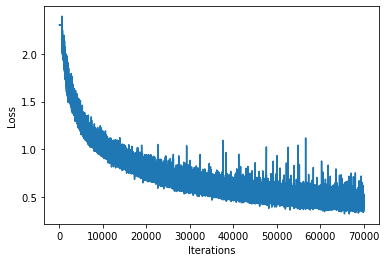

In [40]:
ax = sns.lineplot(data = loss_save.numpy())
ax.set(xlabel = "Iterations", ylabel="Loss")
plt.show()

In [63]:
def custom_viz(kernels, cols=None):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.

    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)

    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)

    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    columns = C
    if cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)

    plt.show()

## Activations Visualsation

torch.Size([3, 32, 32])


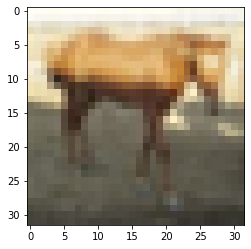

In [125]:
img = train_data[2000][0]
_to_pil = transforms.ToPILImage()

print(img.shape)
plt.imshow(_to_pil(img))

### Convolution 1

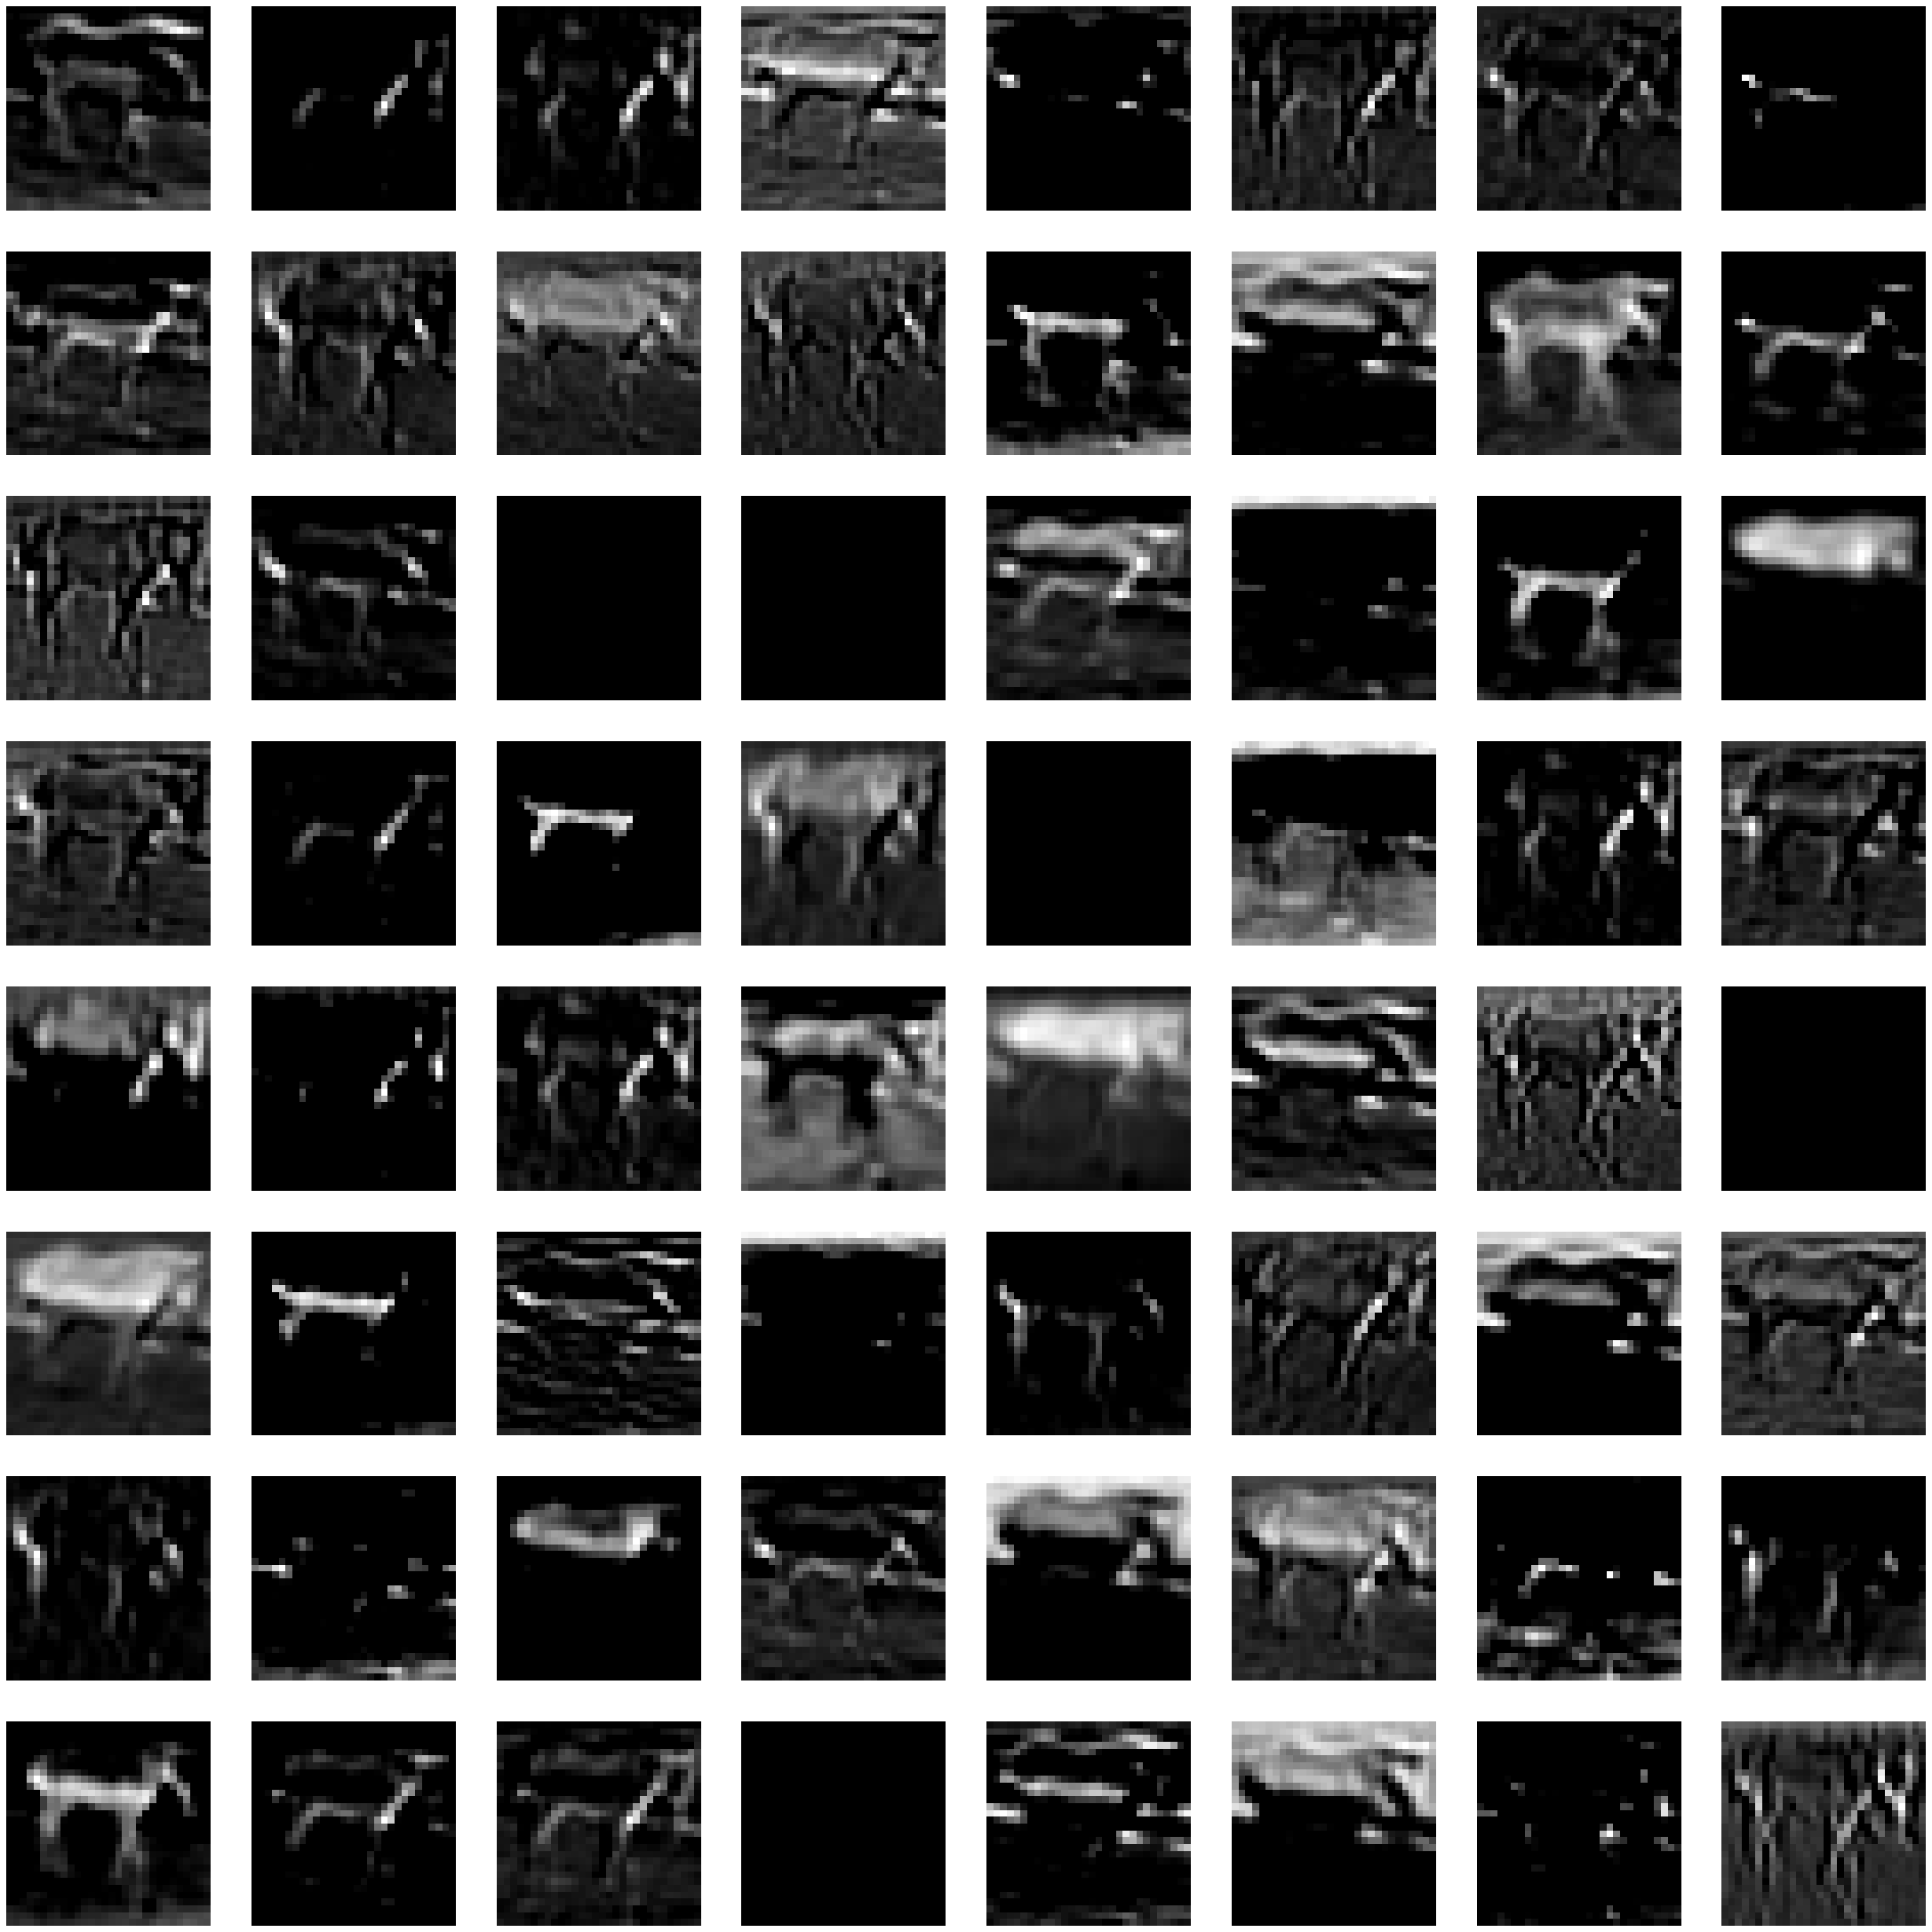

In [126]:
out = model.cnn1(img.expand(1,3,32,32).cuda()) # out = 100,64,30,30
out = model.relu1(out)
custom_viz(out.cpu().detach().clone(),8)

### Convolution 2

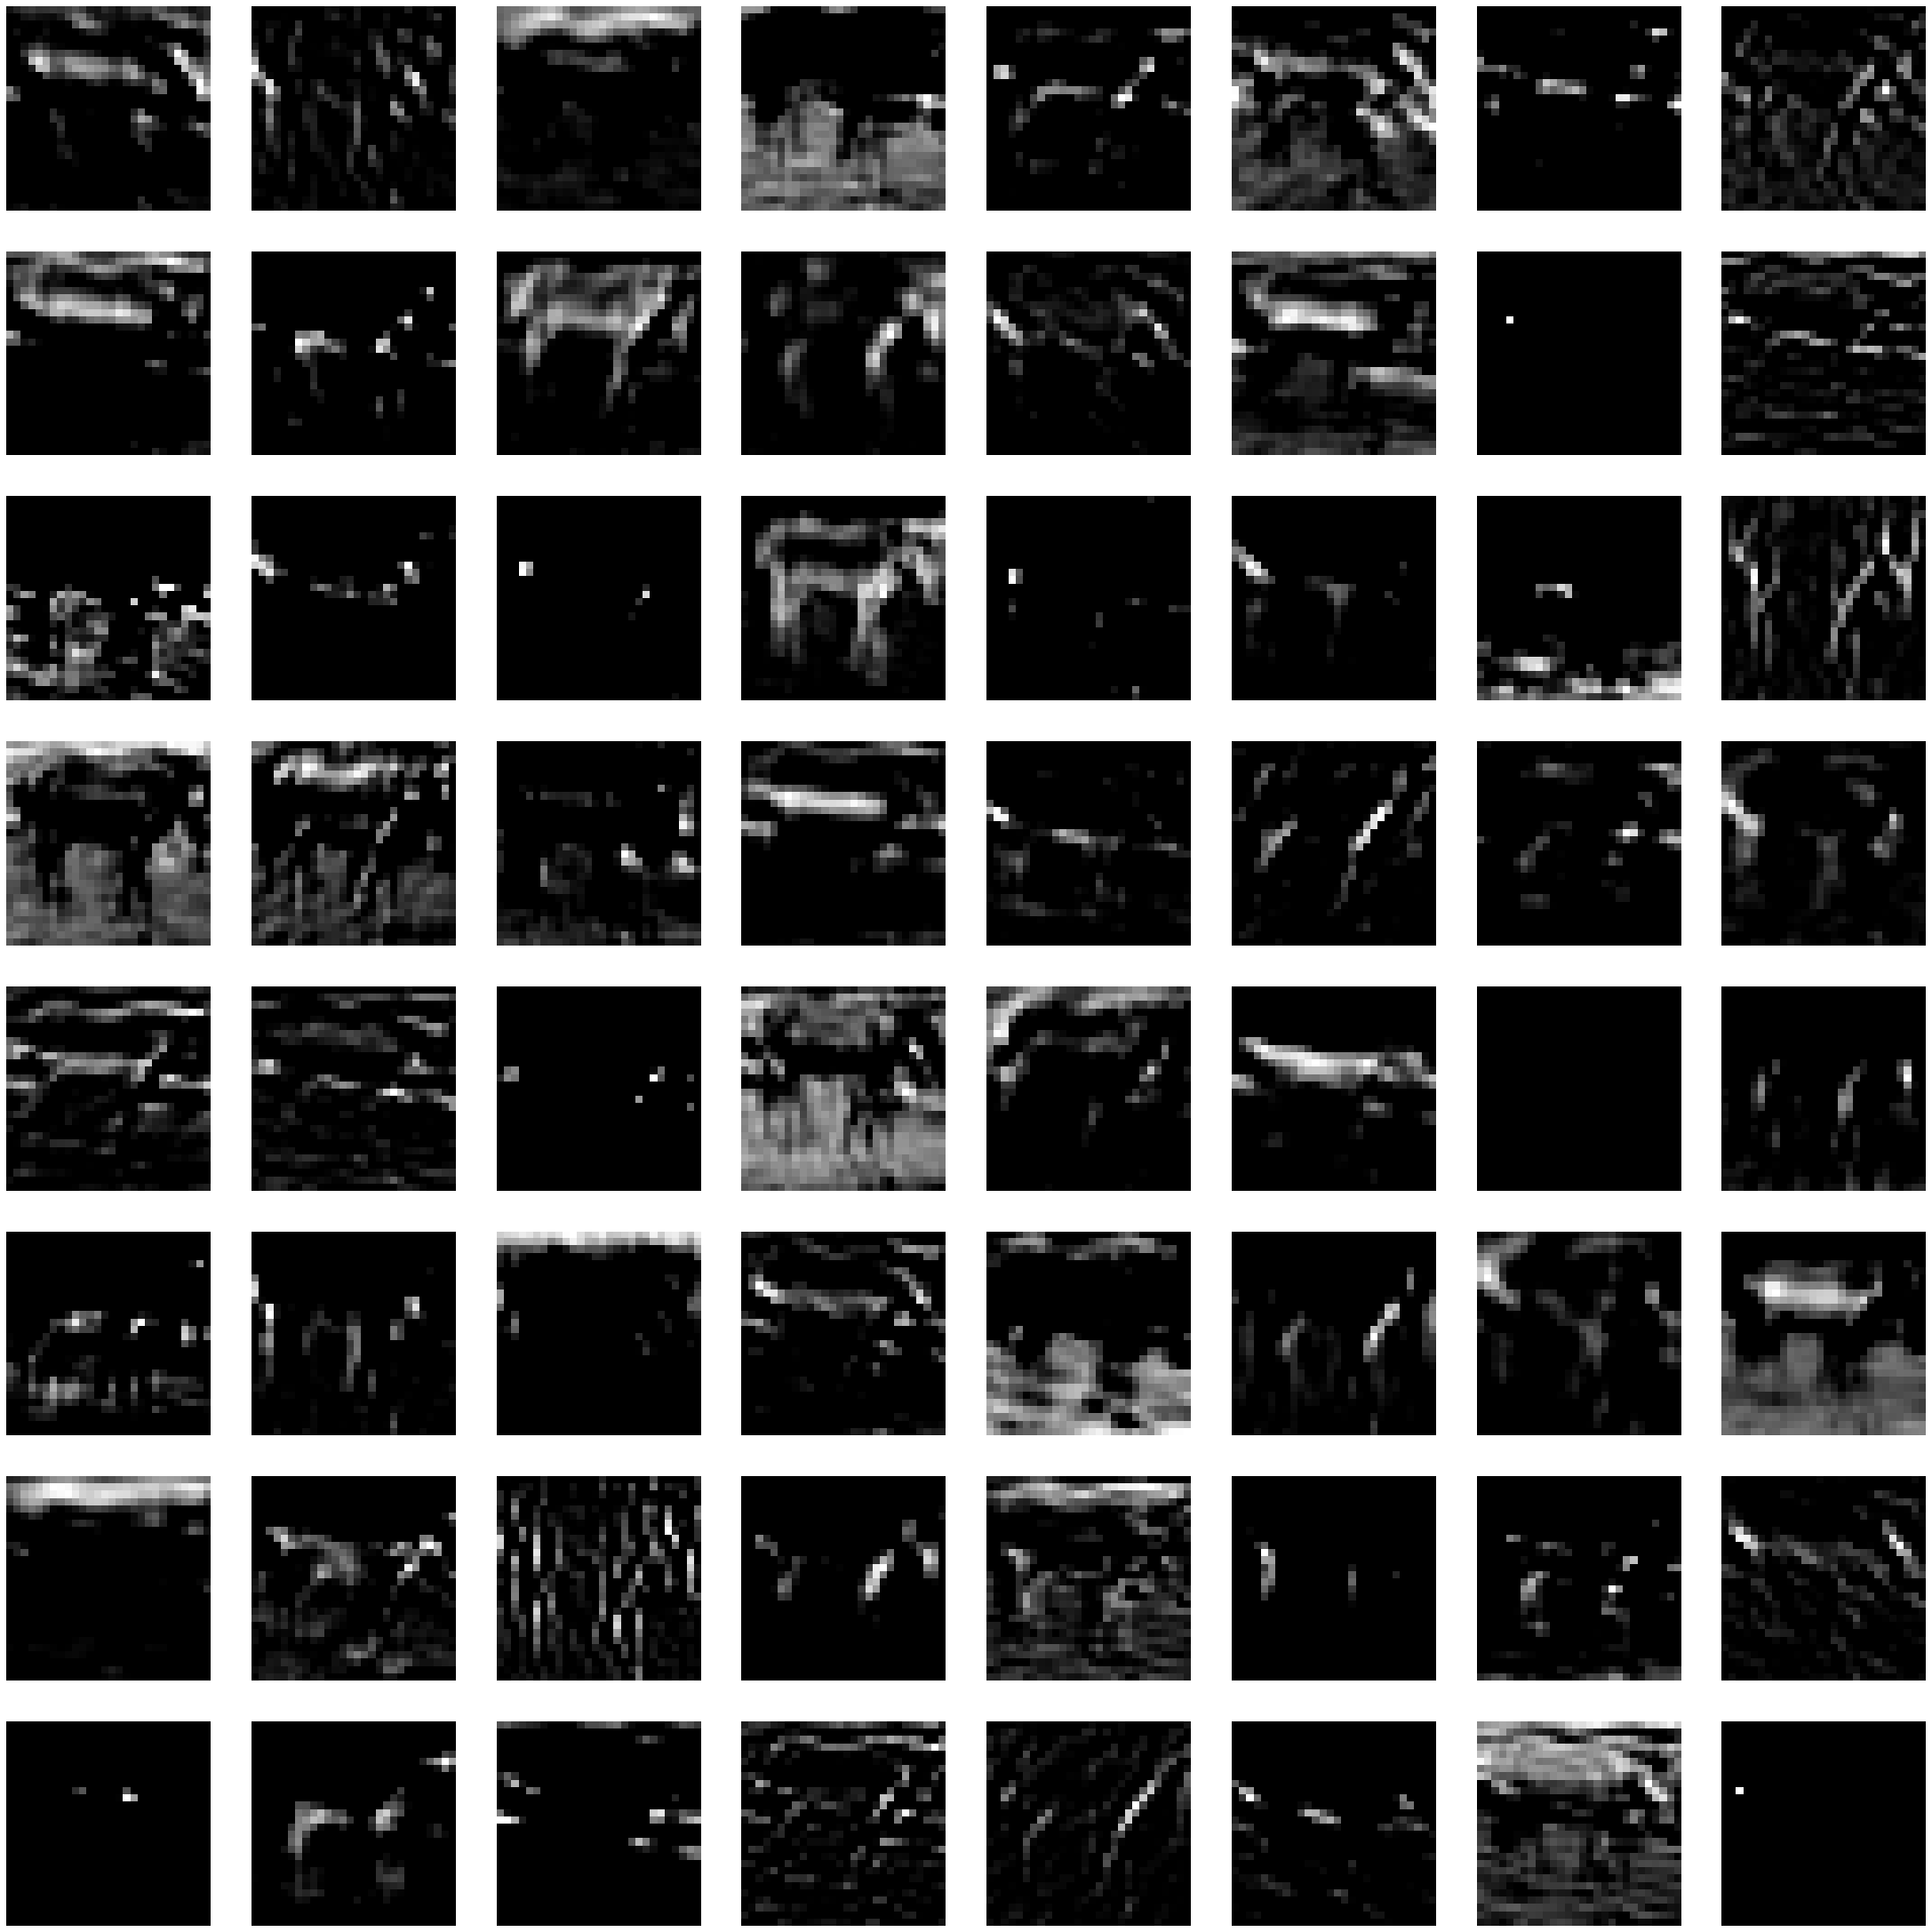

In [127]:
out = model.cnn2(out) # out = 100,64,28,28
out = model.relu2(out)
custom_viz(out.cpu().detach().clone(),8)

### Convolution 3

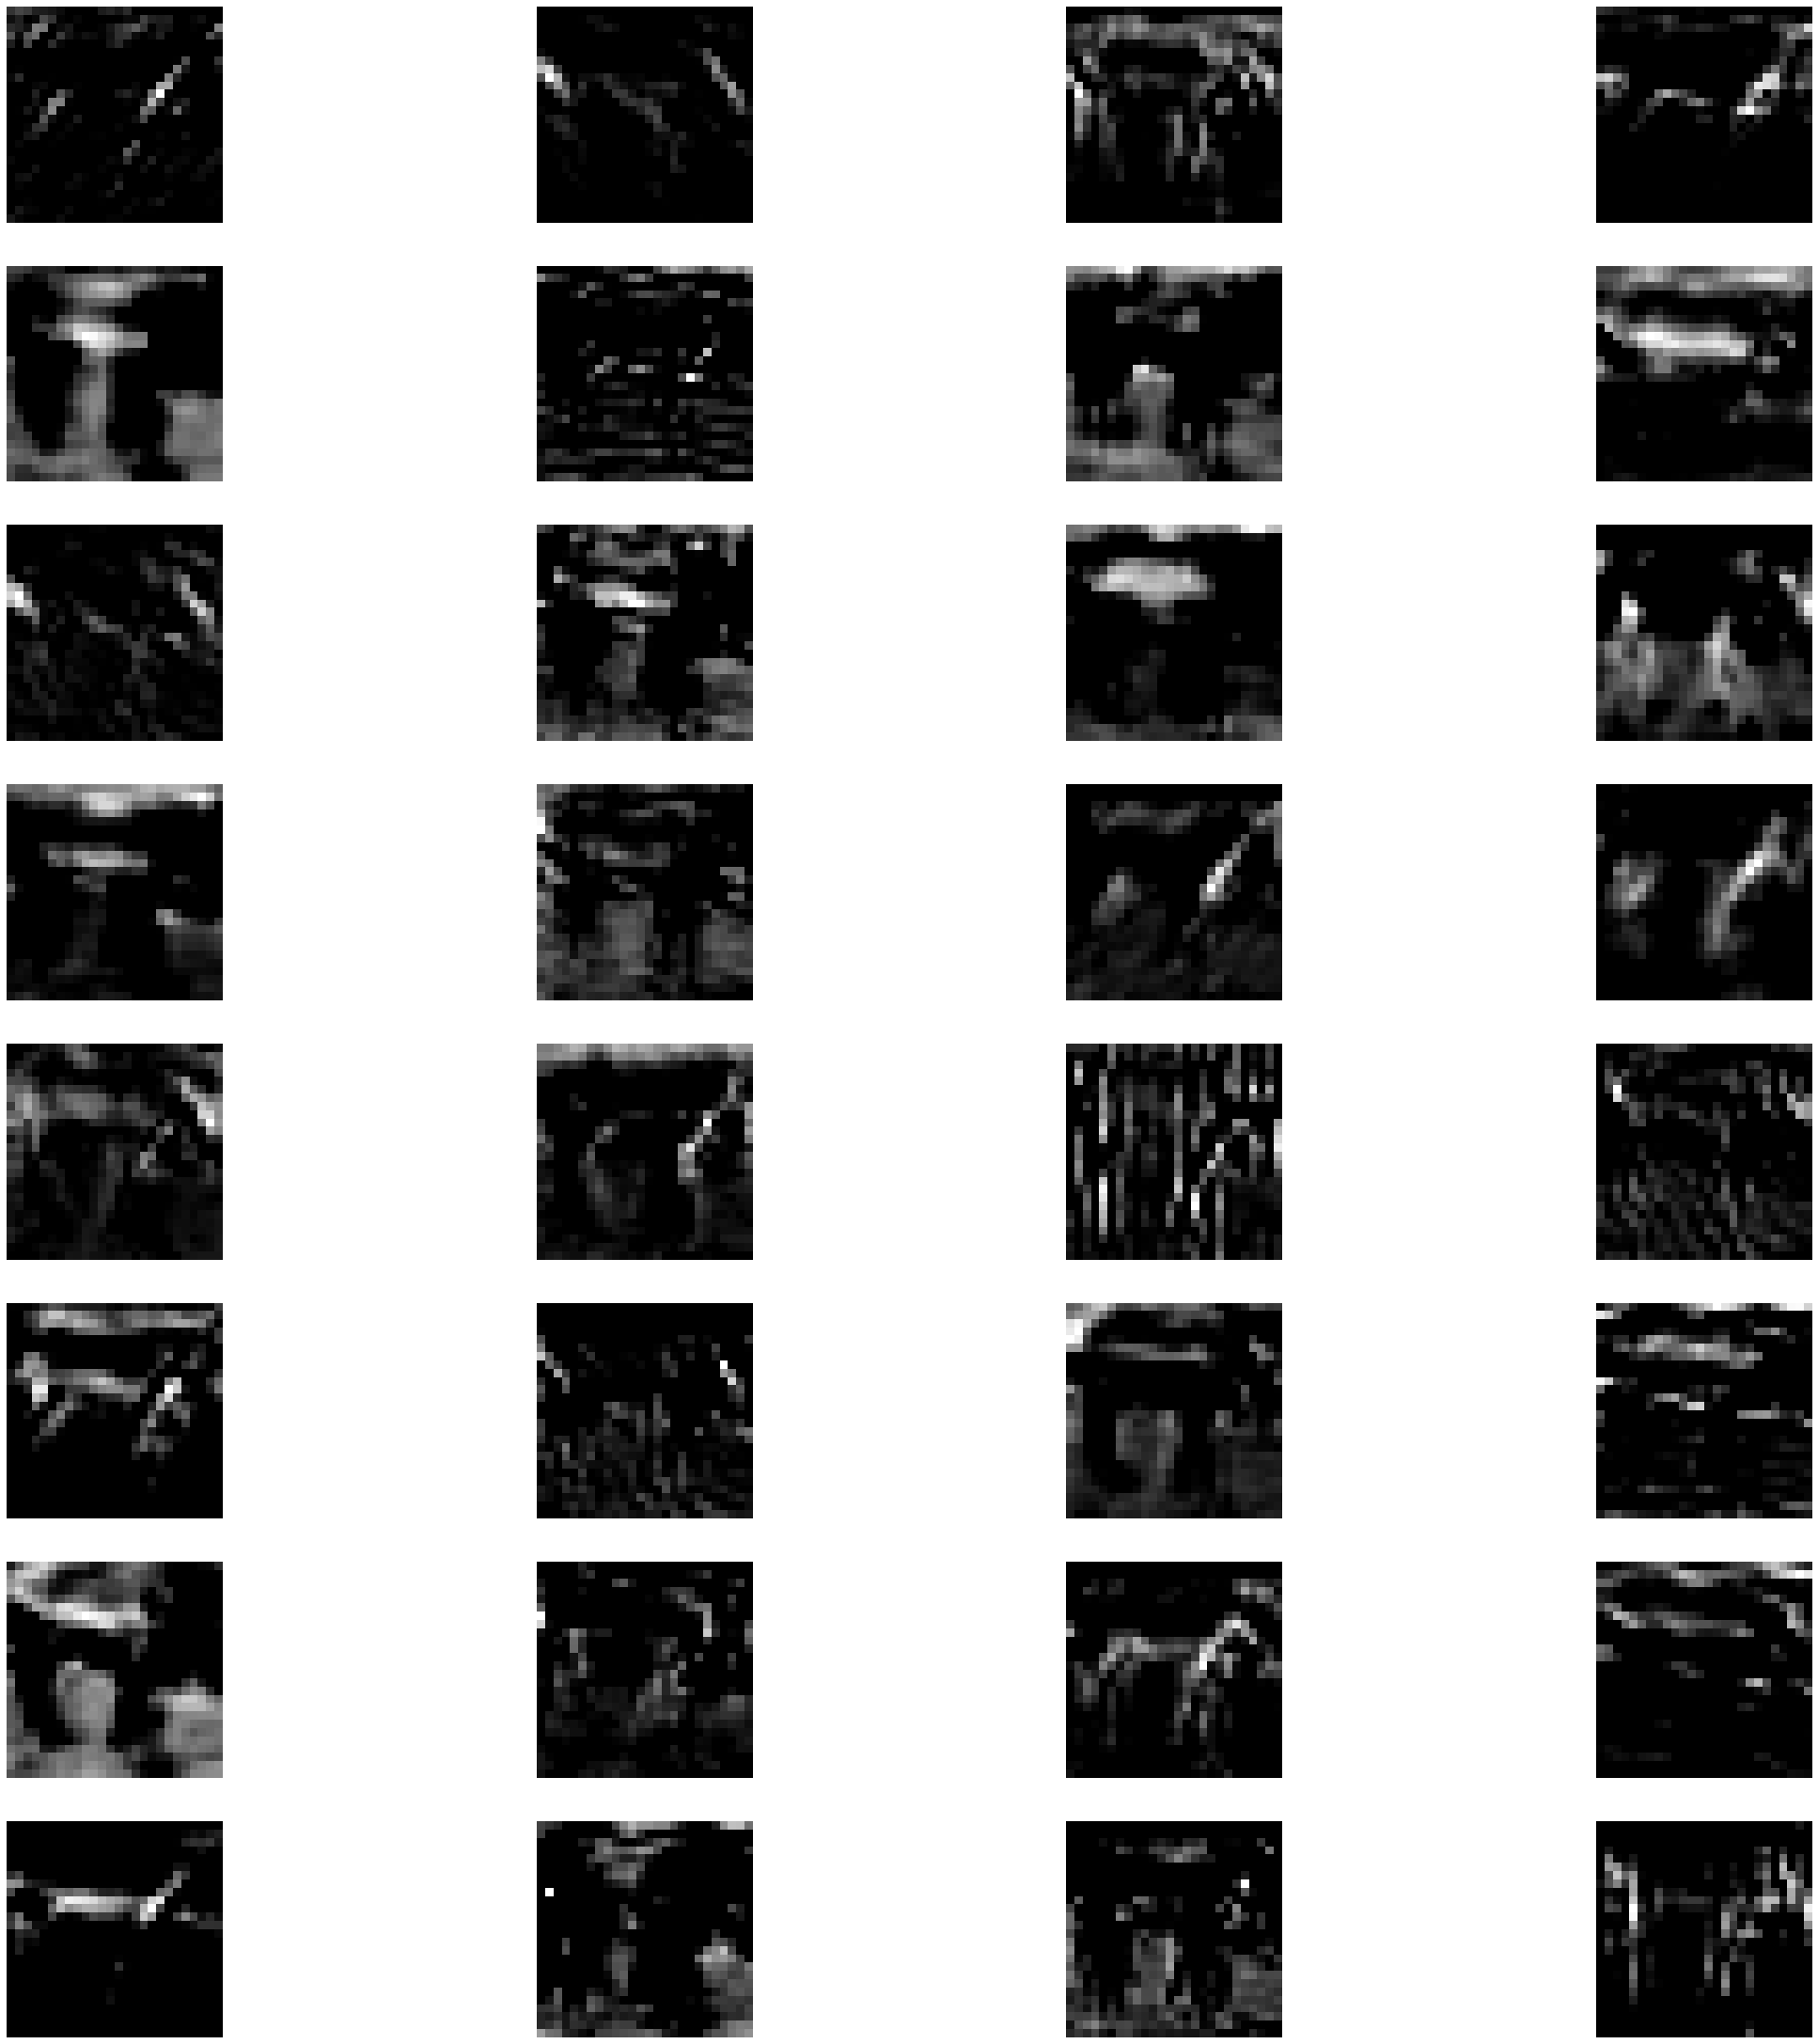

In [128]:
out = model.cnn3(out) # out = 100,32,26,26
out = model.relu3(out)
custom_viz(out.cpu().detach().clone(),4)

In [129]:
# Maxpool 1
out = model.maxpool3(out) # out = 100,32,13,13

### Convolution 4

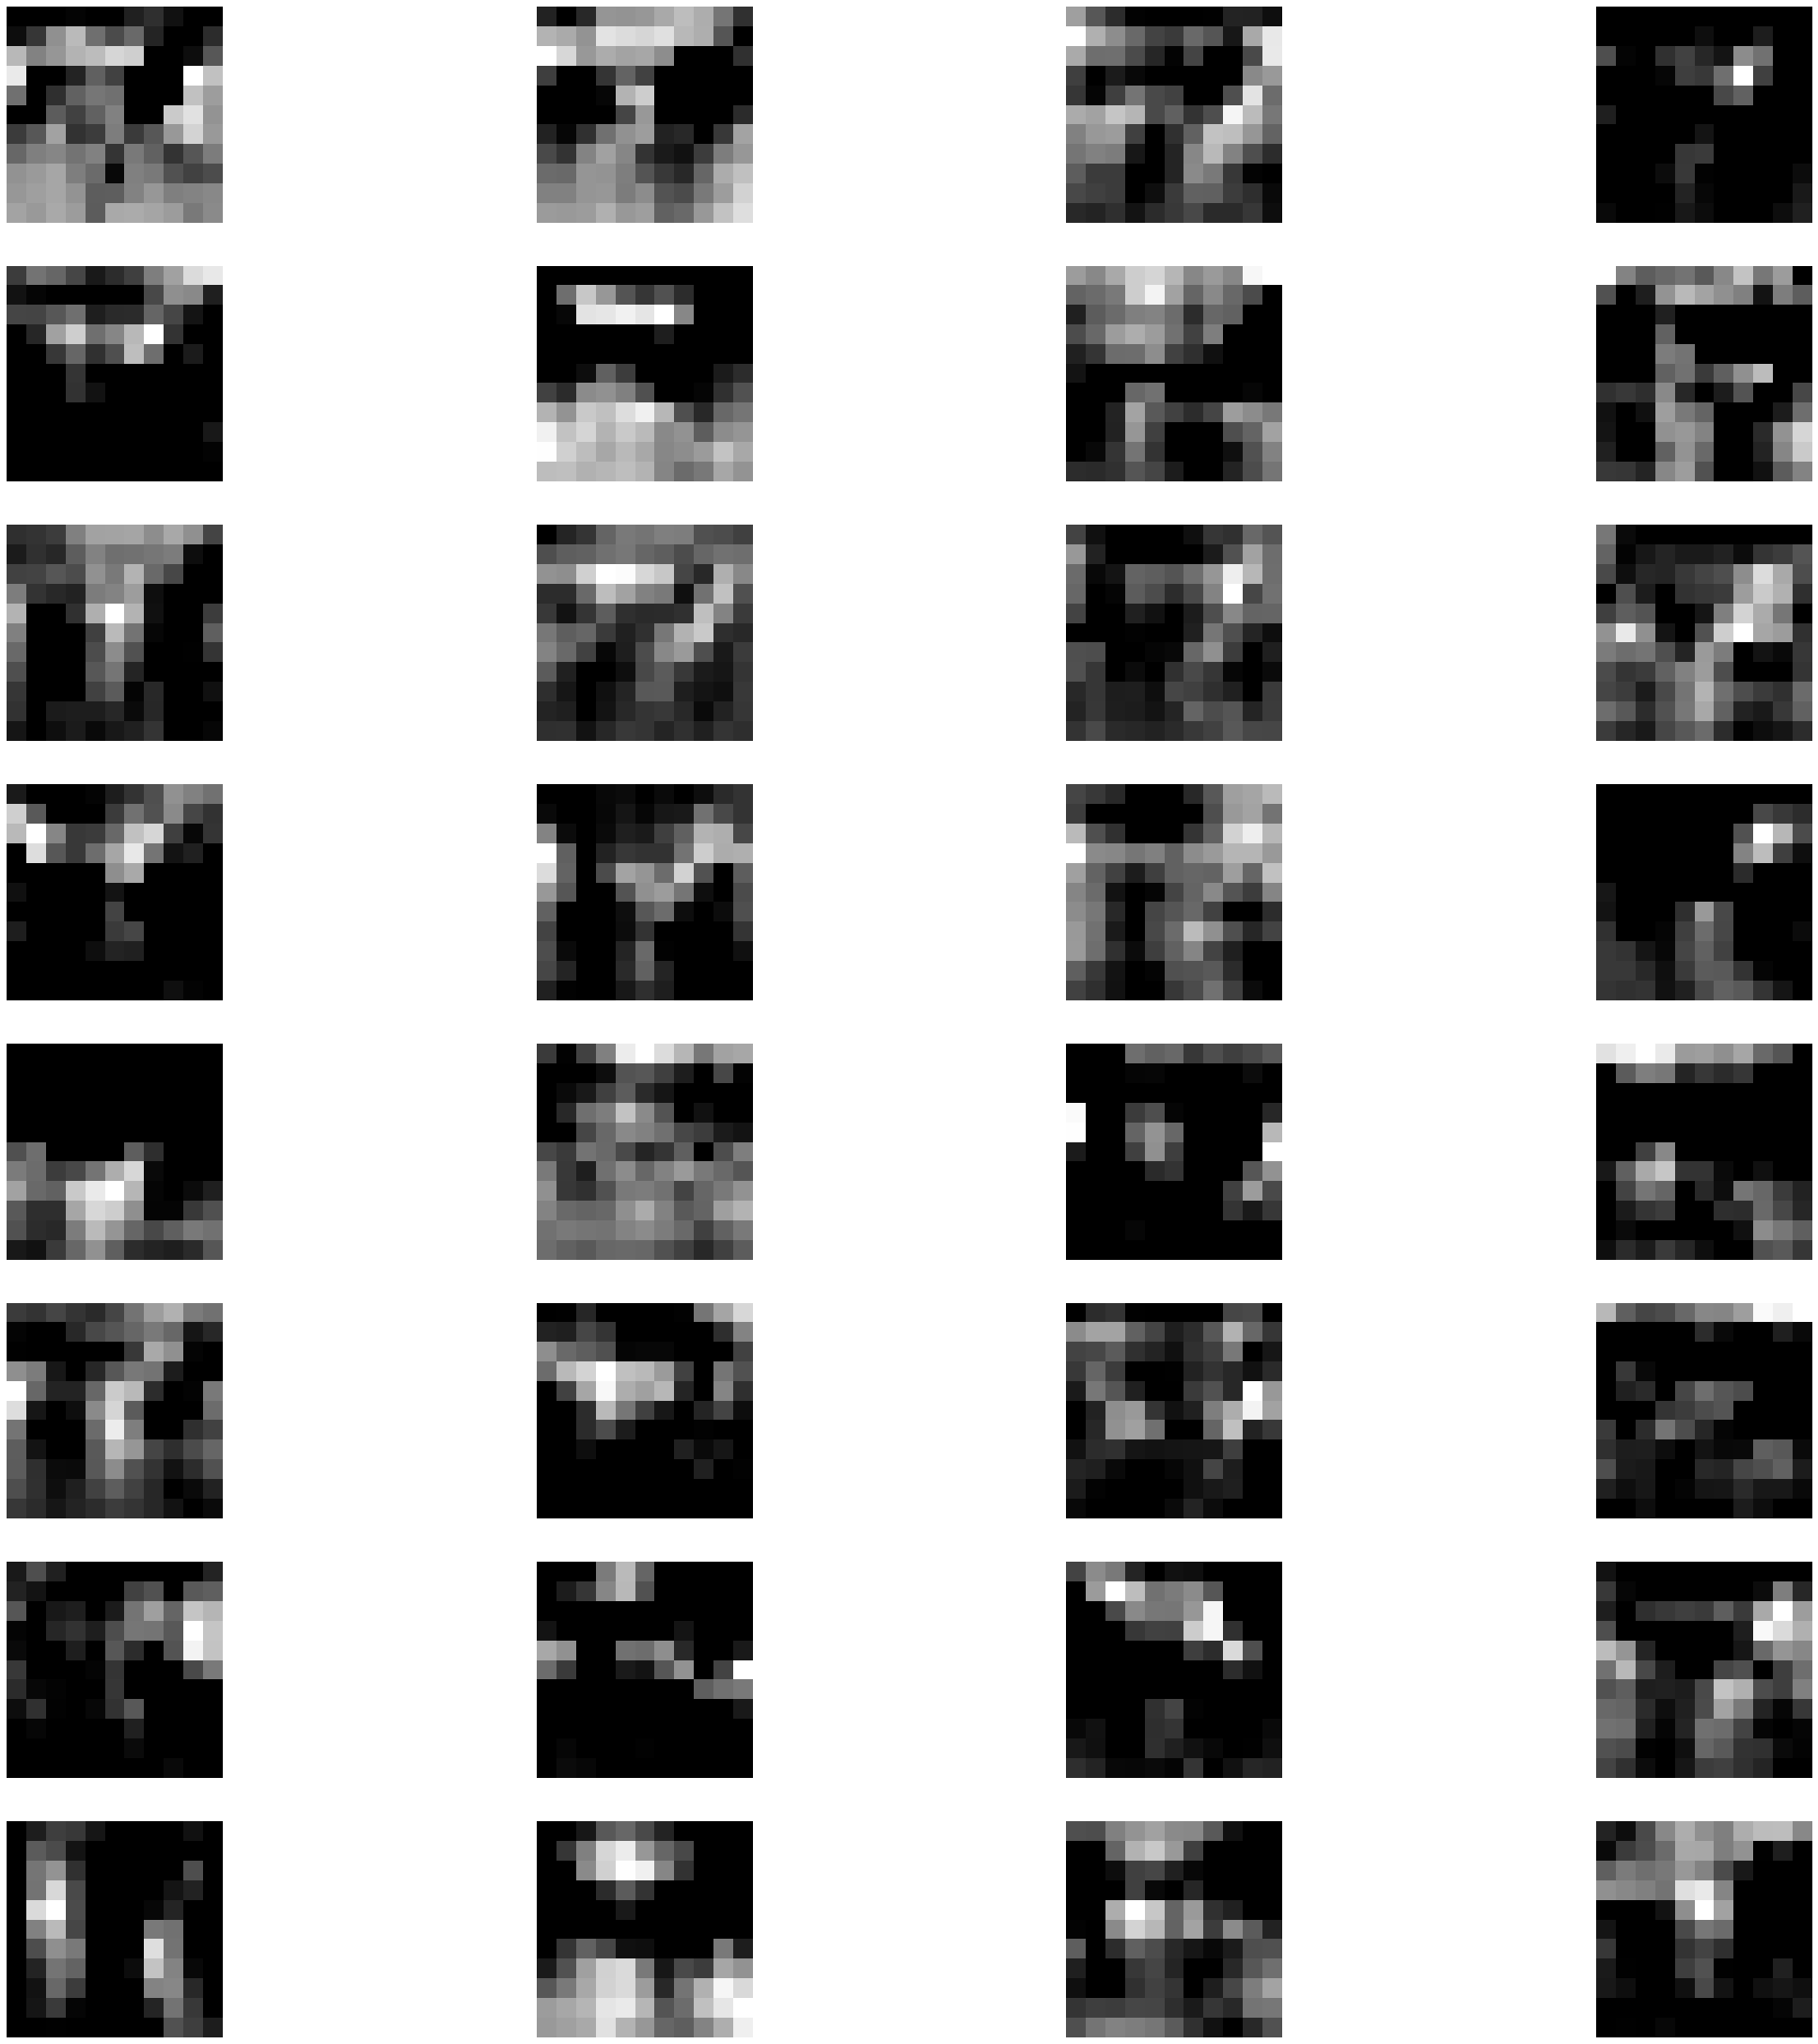

In [130]:
out = model.cnn4(out) # out = 100,32,11,11
out = model.relu4(out)
custom_viz(out.cpu().detach().clone(),4)

### Convolution 5

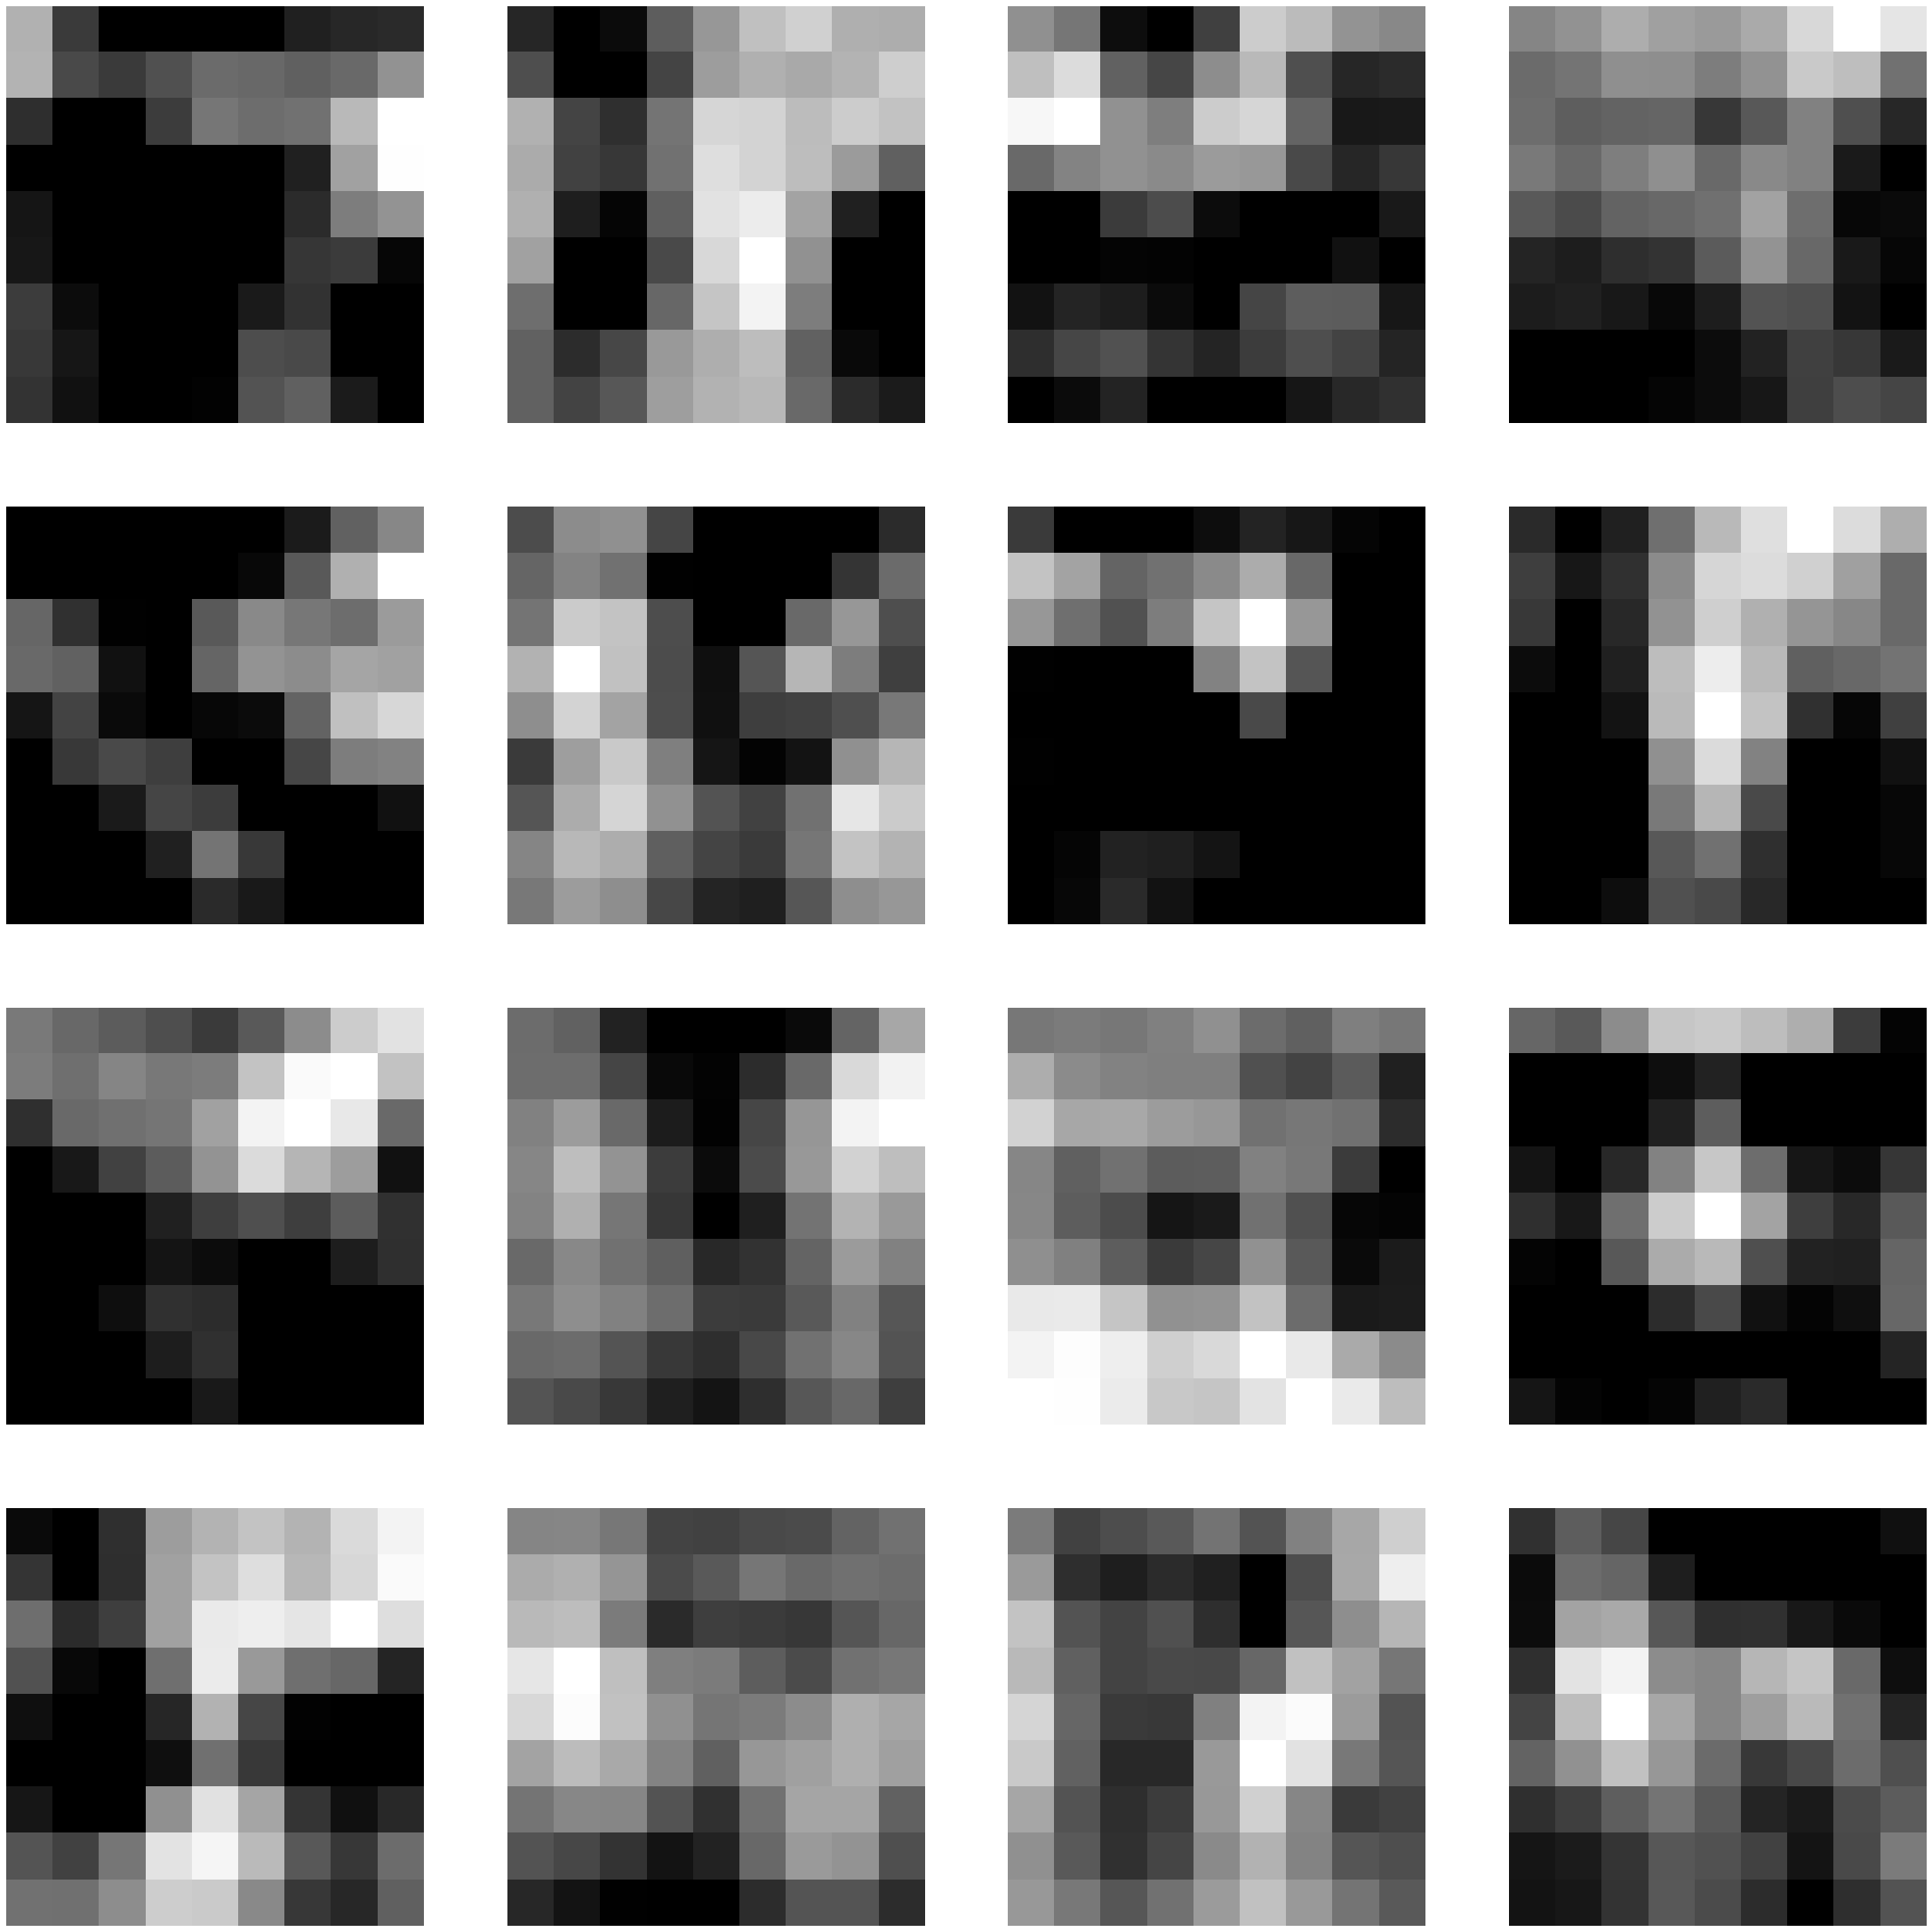

In [131]:
out = model.cnn5(out) # out = 100,16,9,9
out = model.relu5(out)
custom_viz(out.cpu().detach().clone(),4)

### Convolution 6

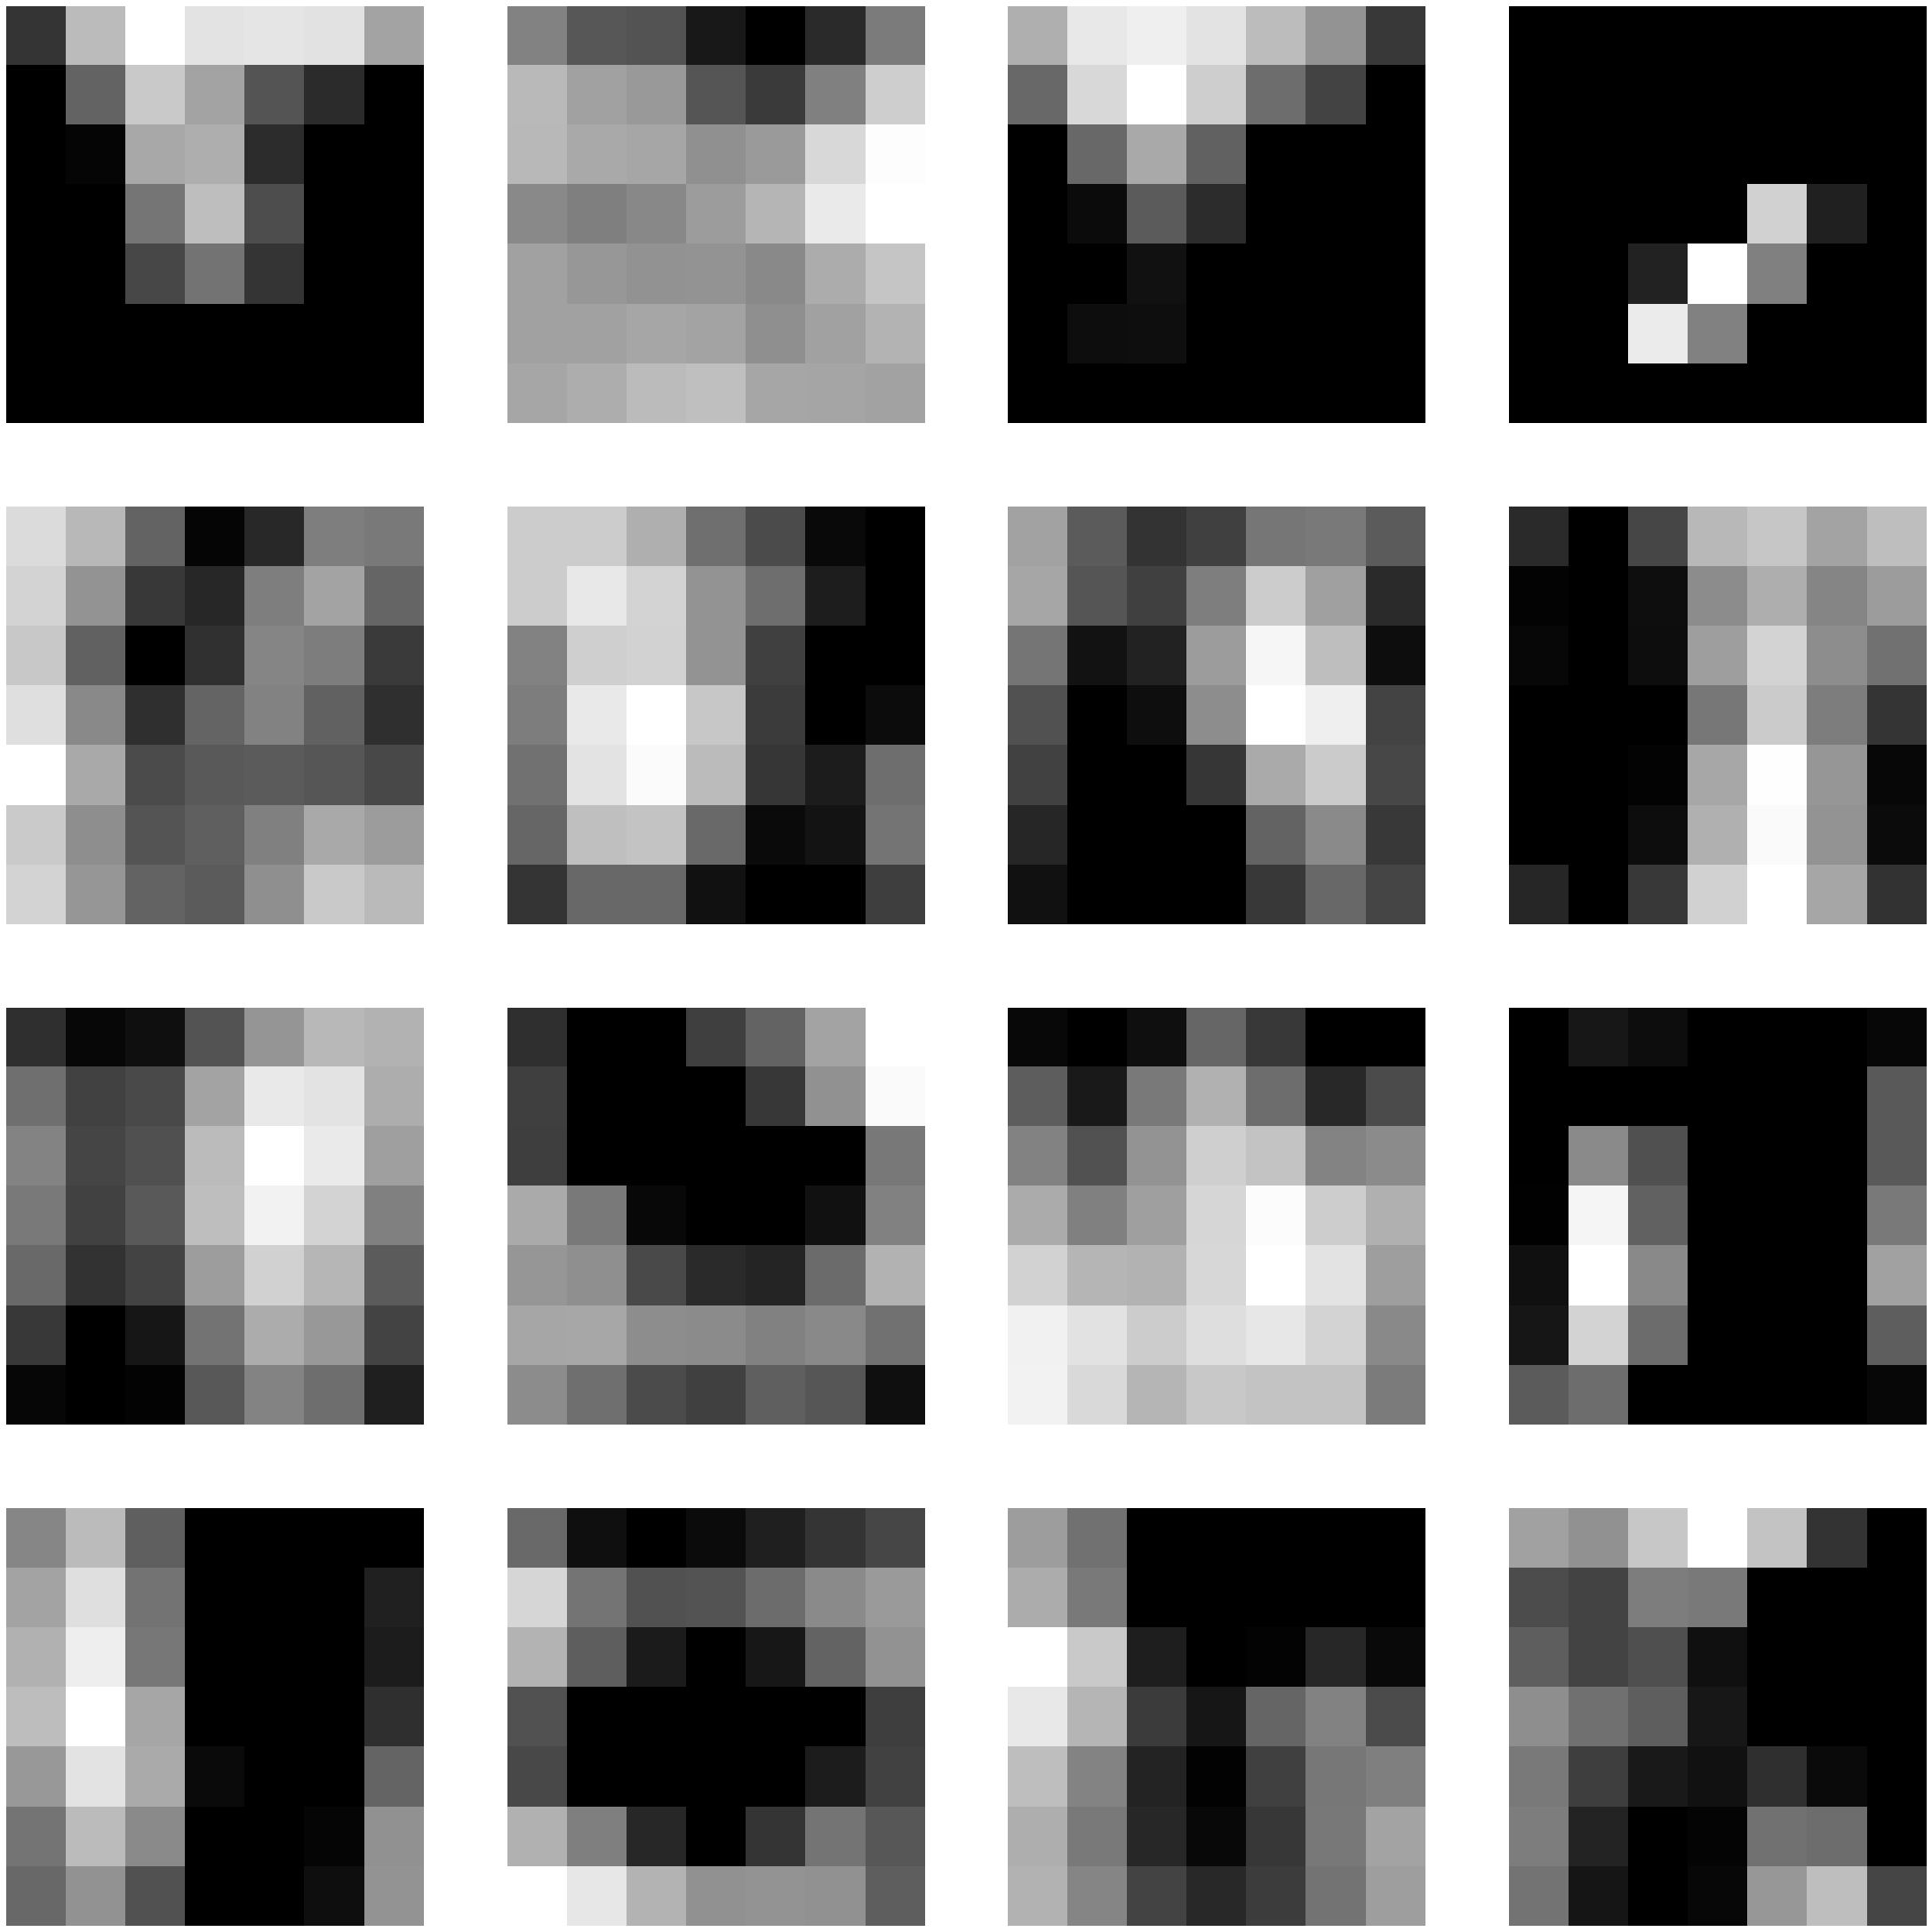

In [132]:
out = model.cnn6(out) # out = 100,16,7,7
out = model.relu6(out)
custom_viz(out.cpu().detach().clone(),4)

## Filter Visualisation

### Convolution 1

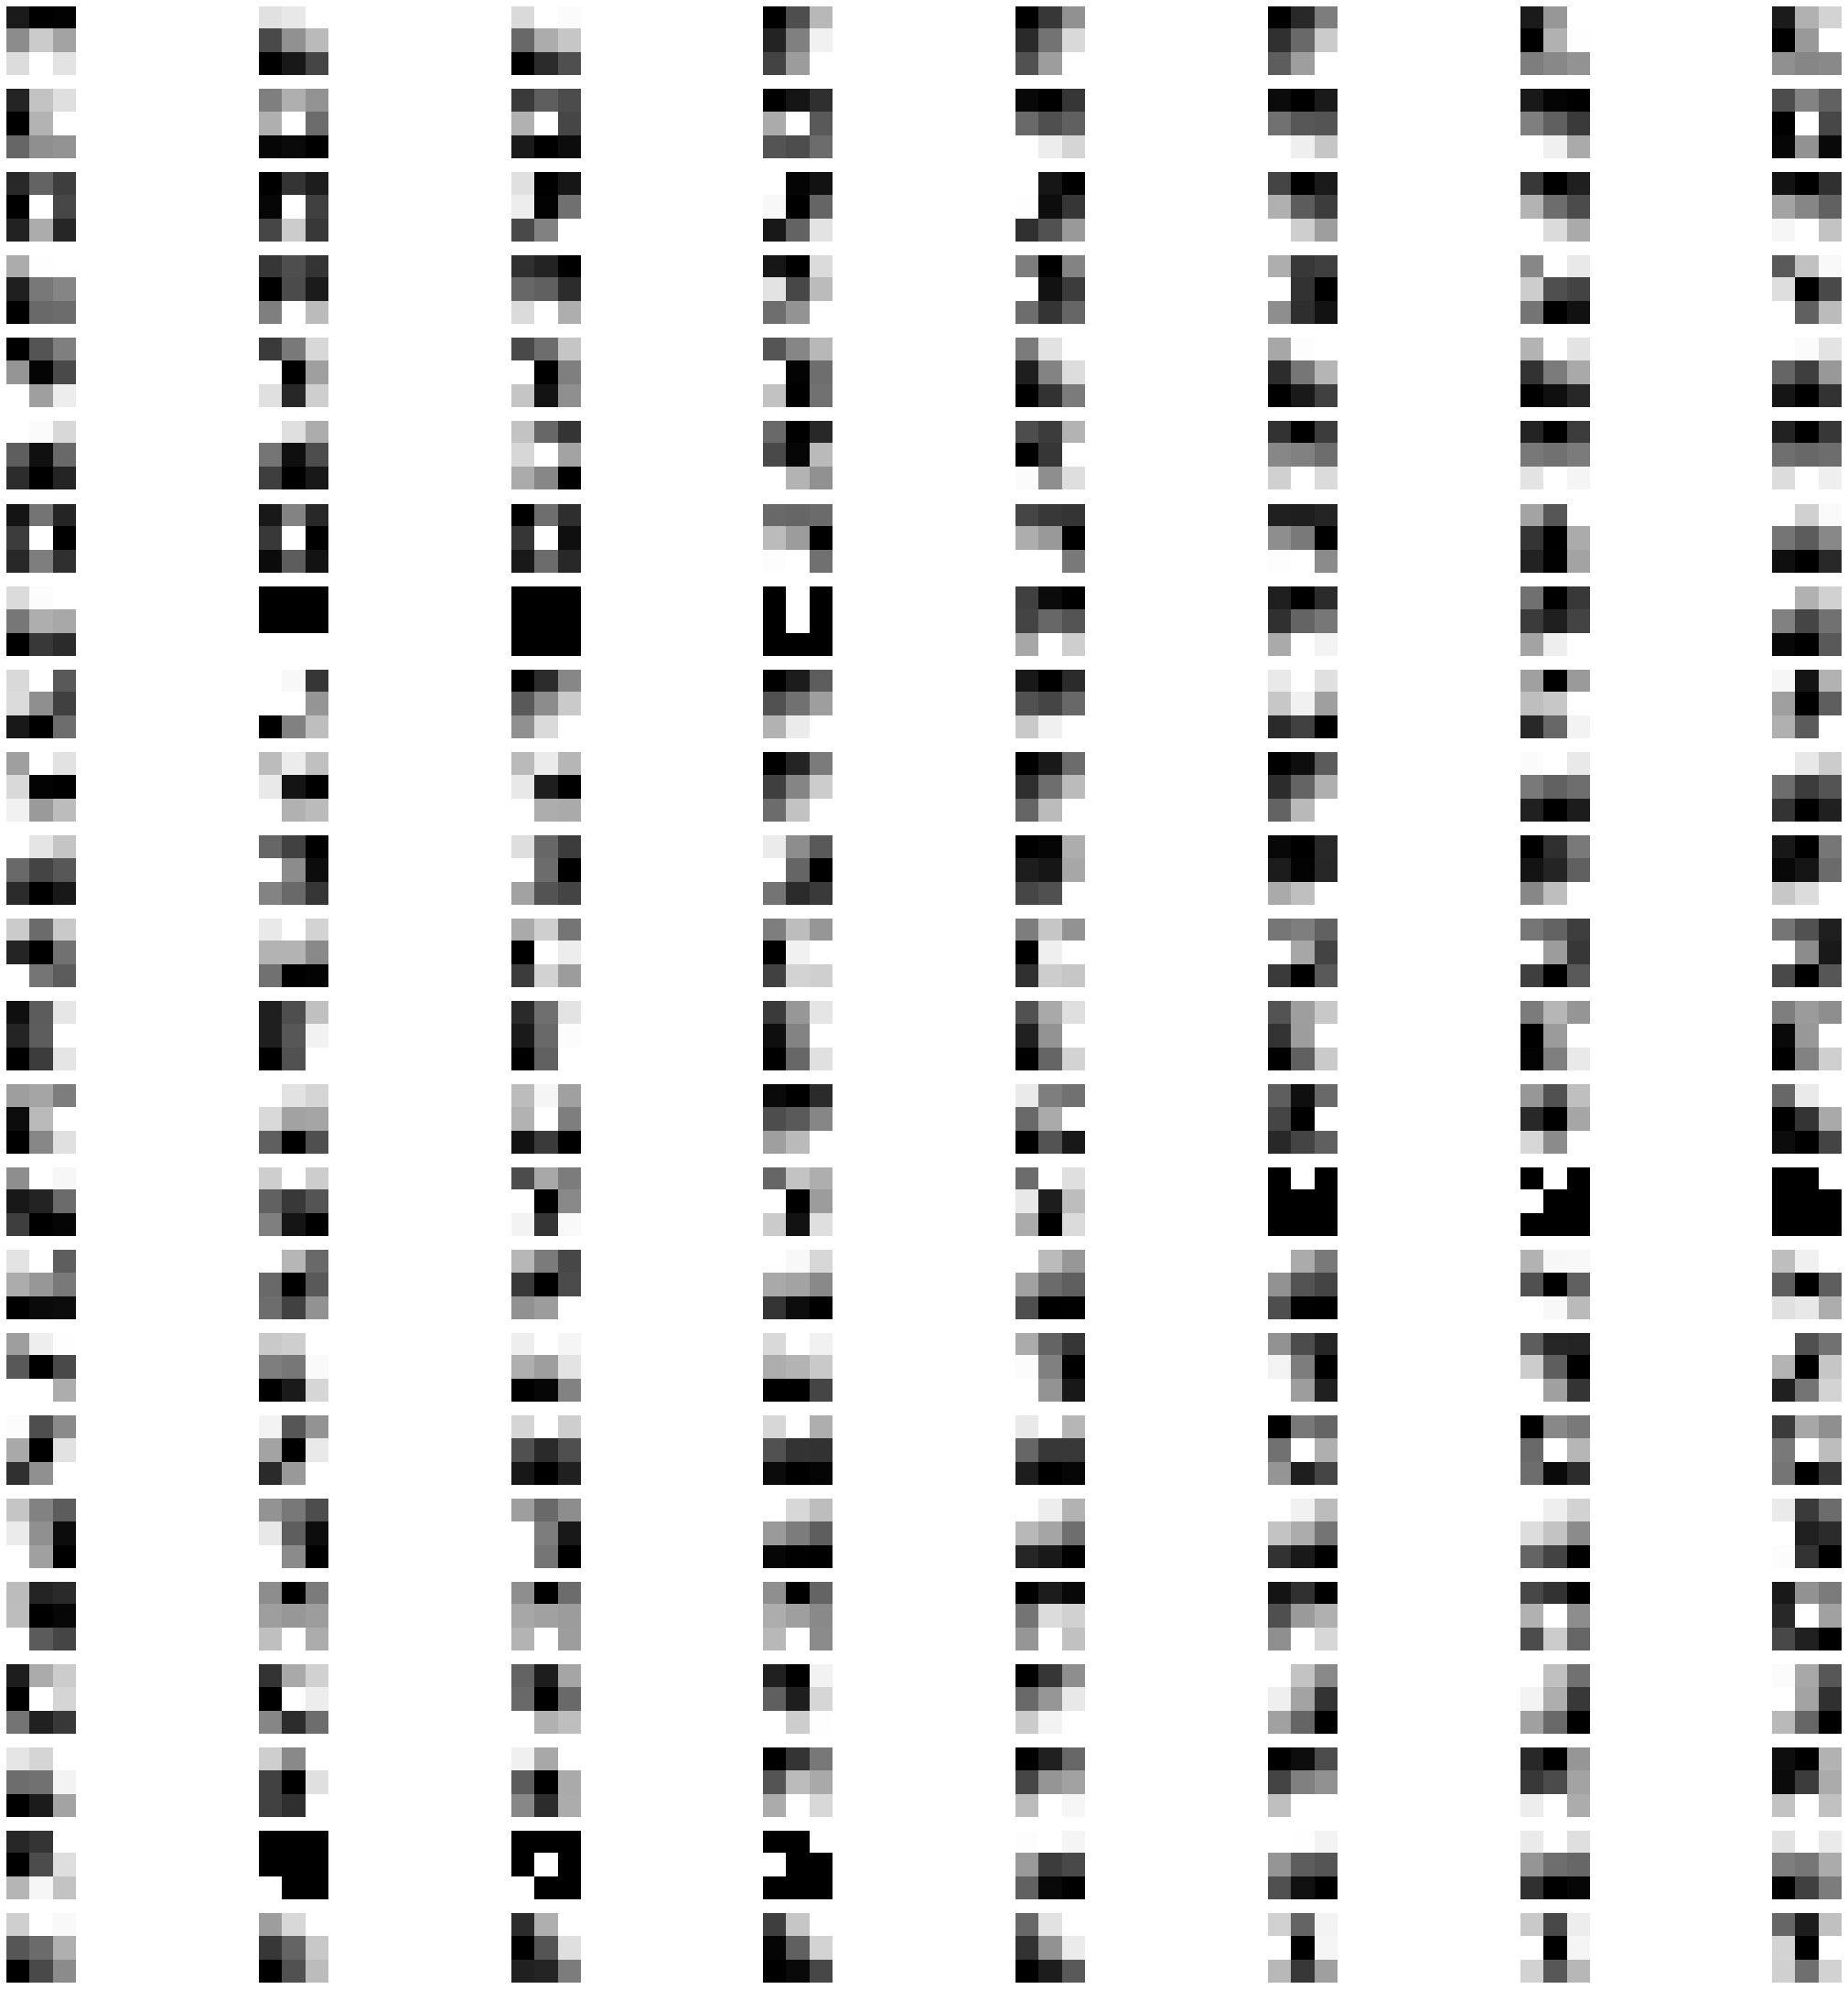

In [74]:
kernels = model.cnn1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels,8)

### Convolution 2

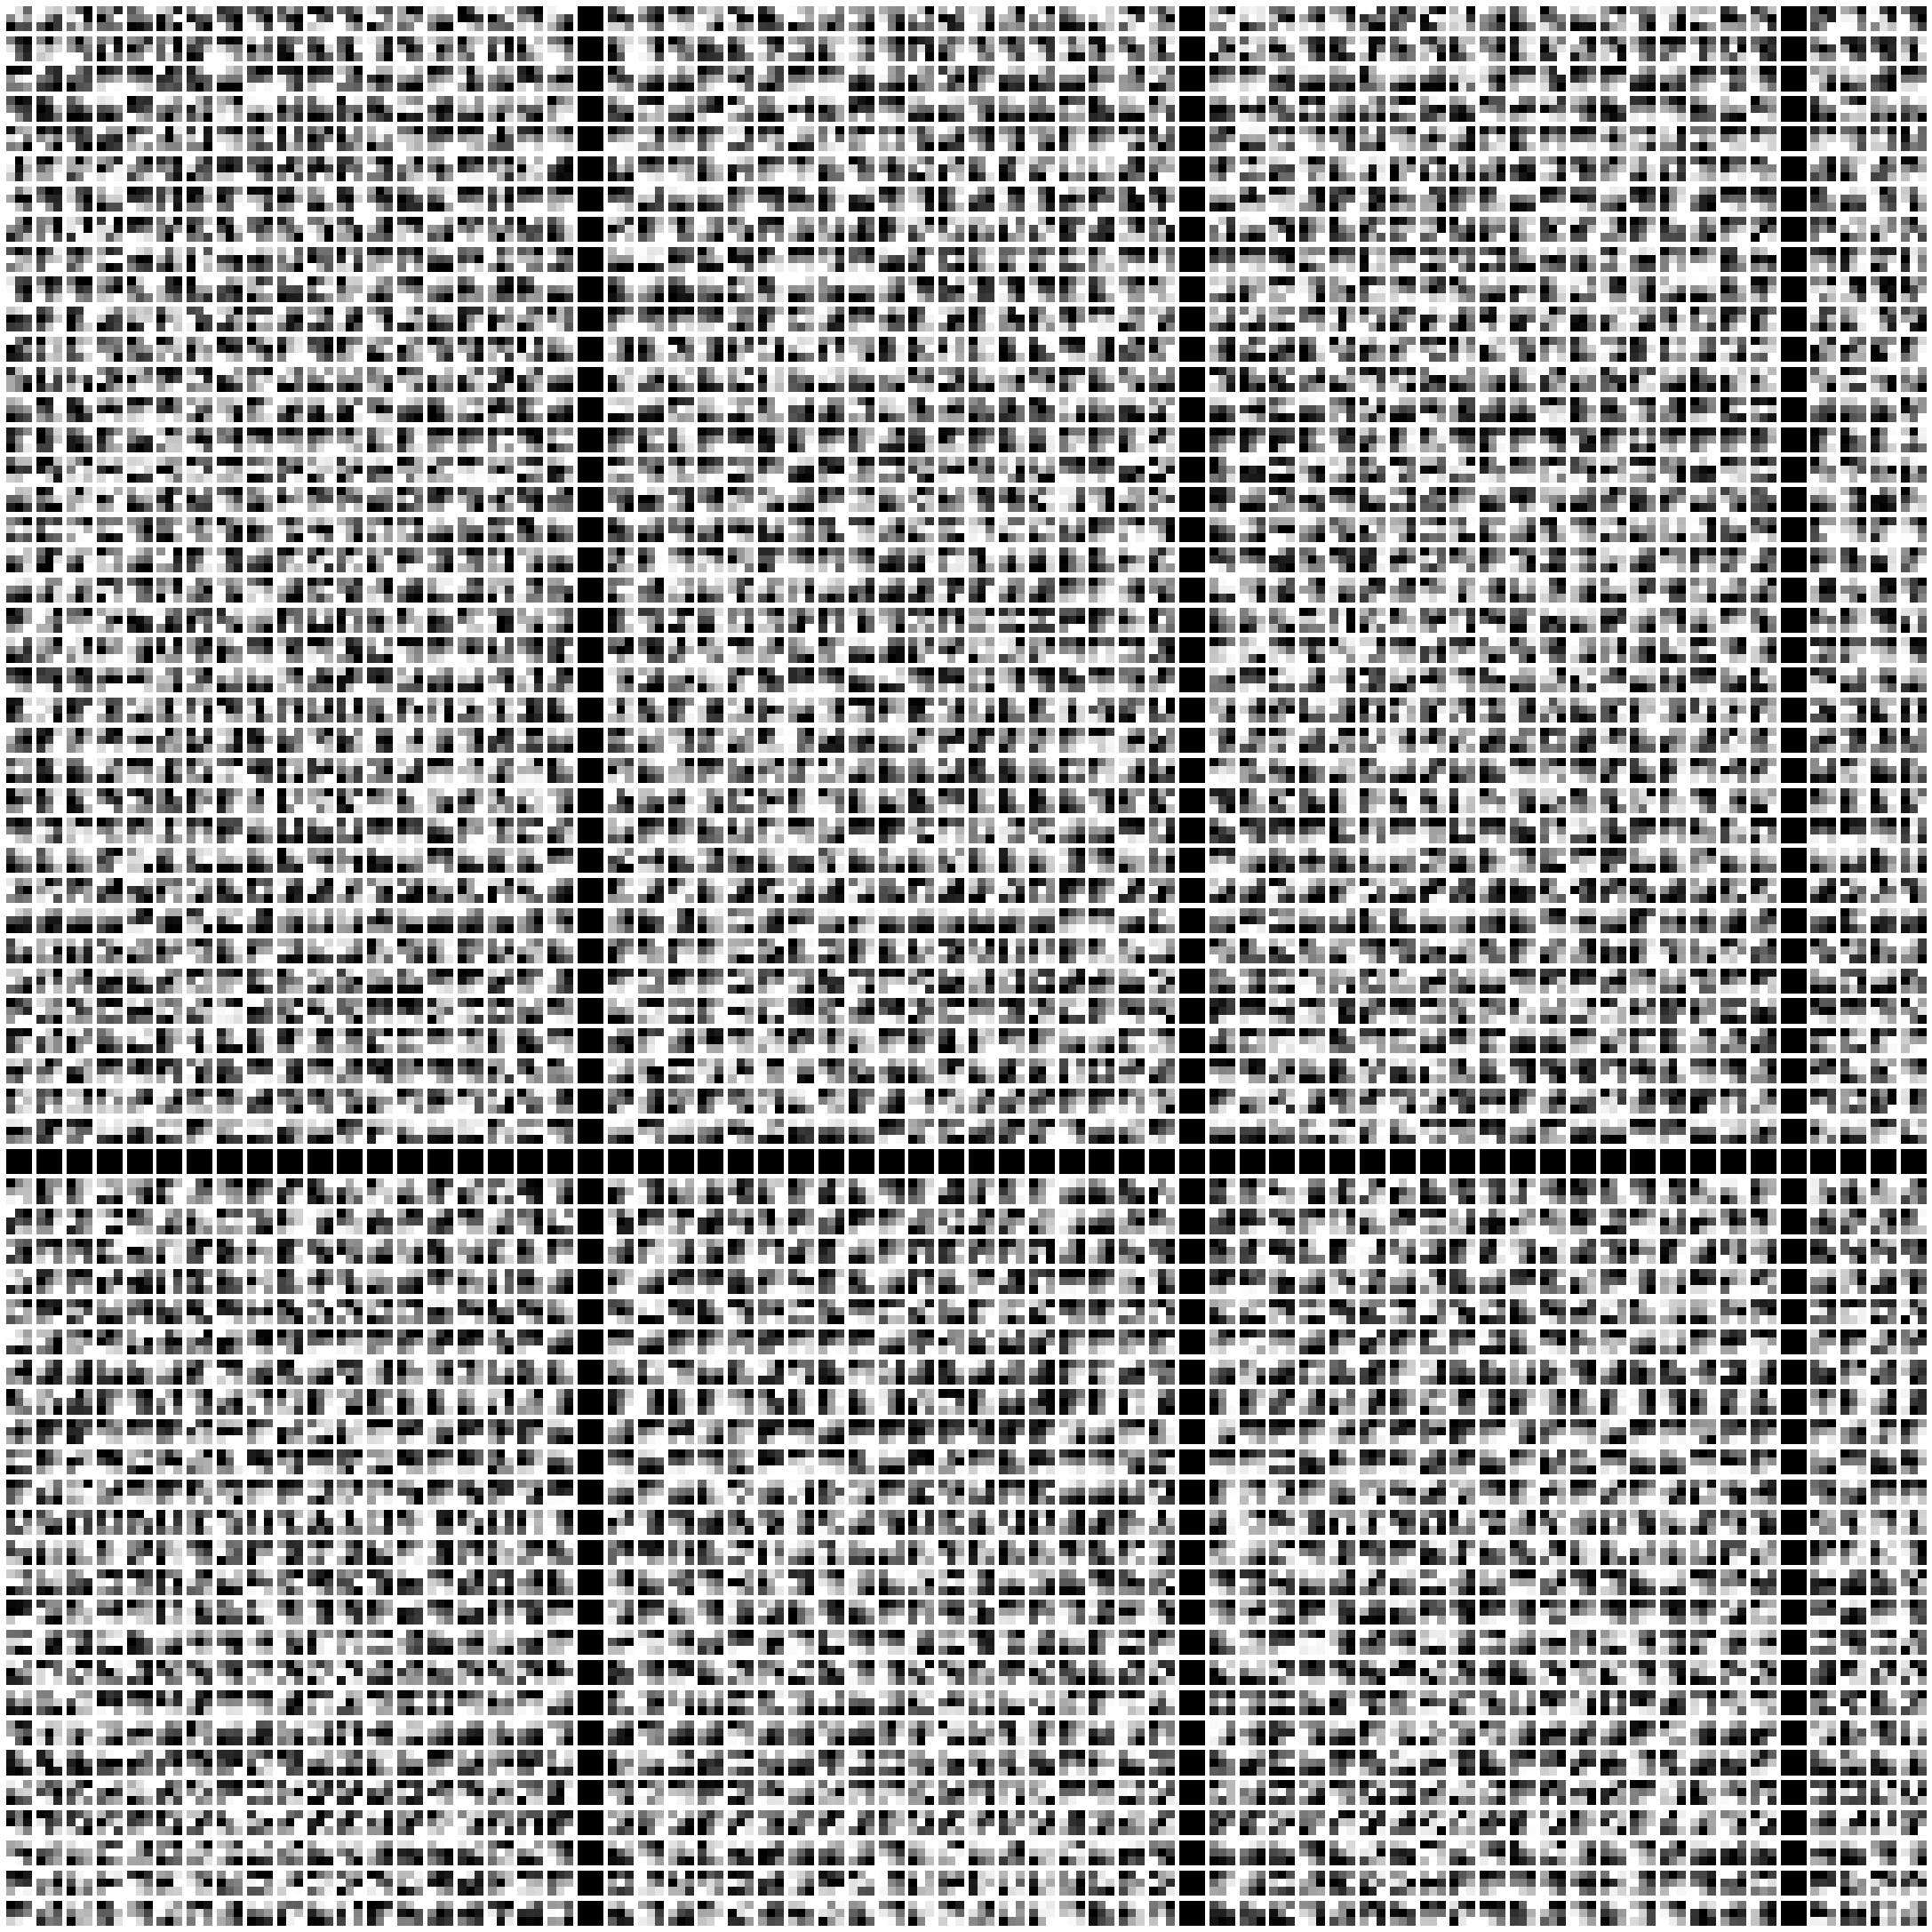

In [69]:
kernels = model.cnn2.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels,64)

### Convolution 3

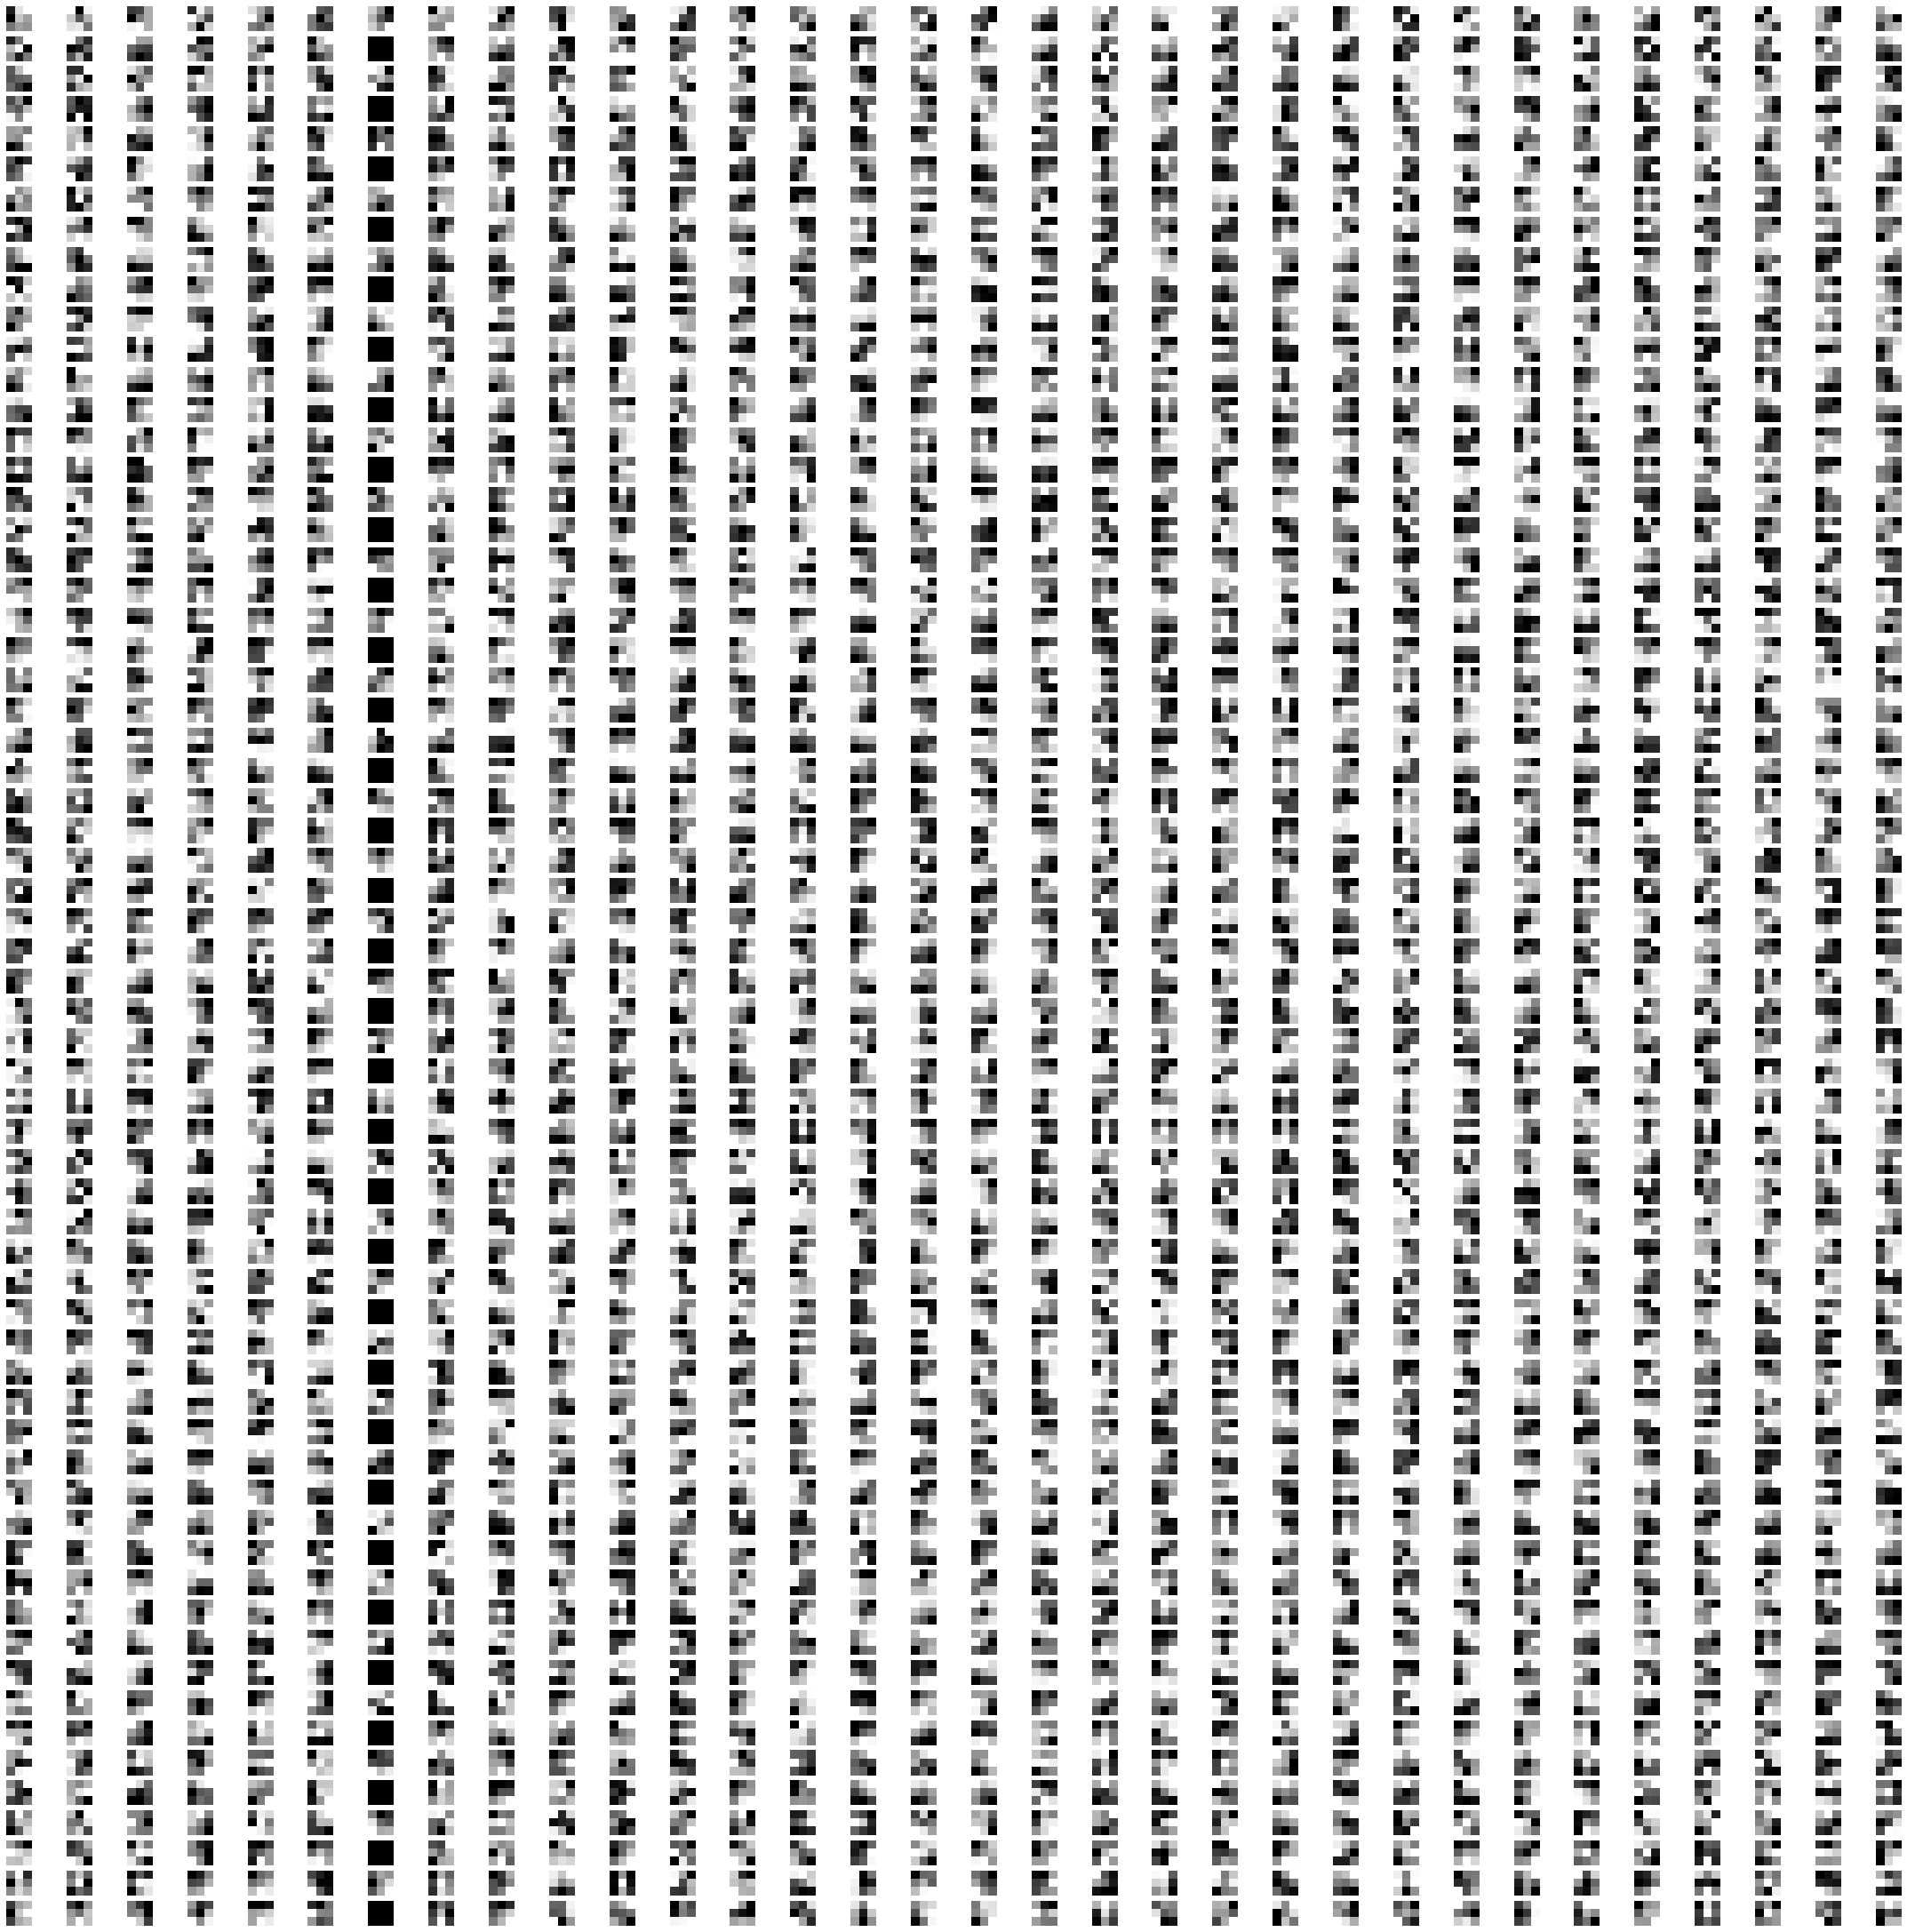

In [70]:
kernels = model.cnn3.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels,32)

### Convolution 4

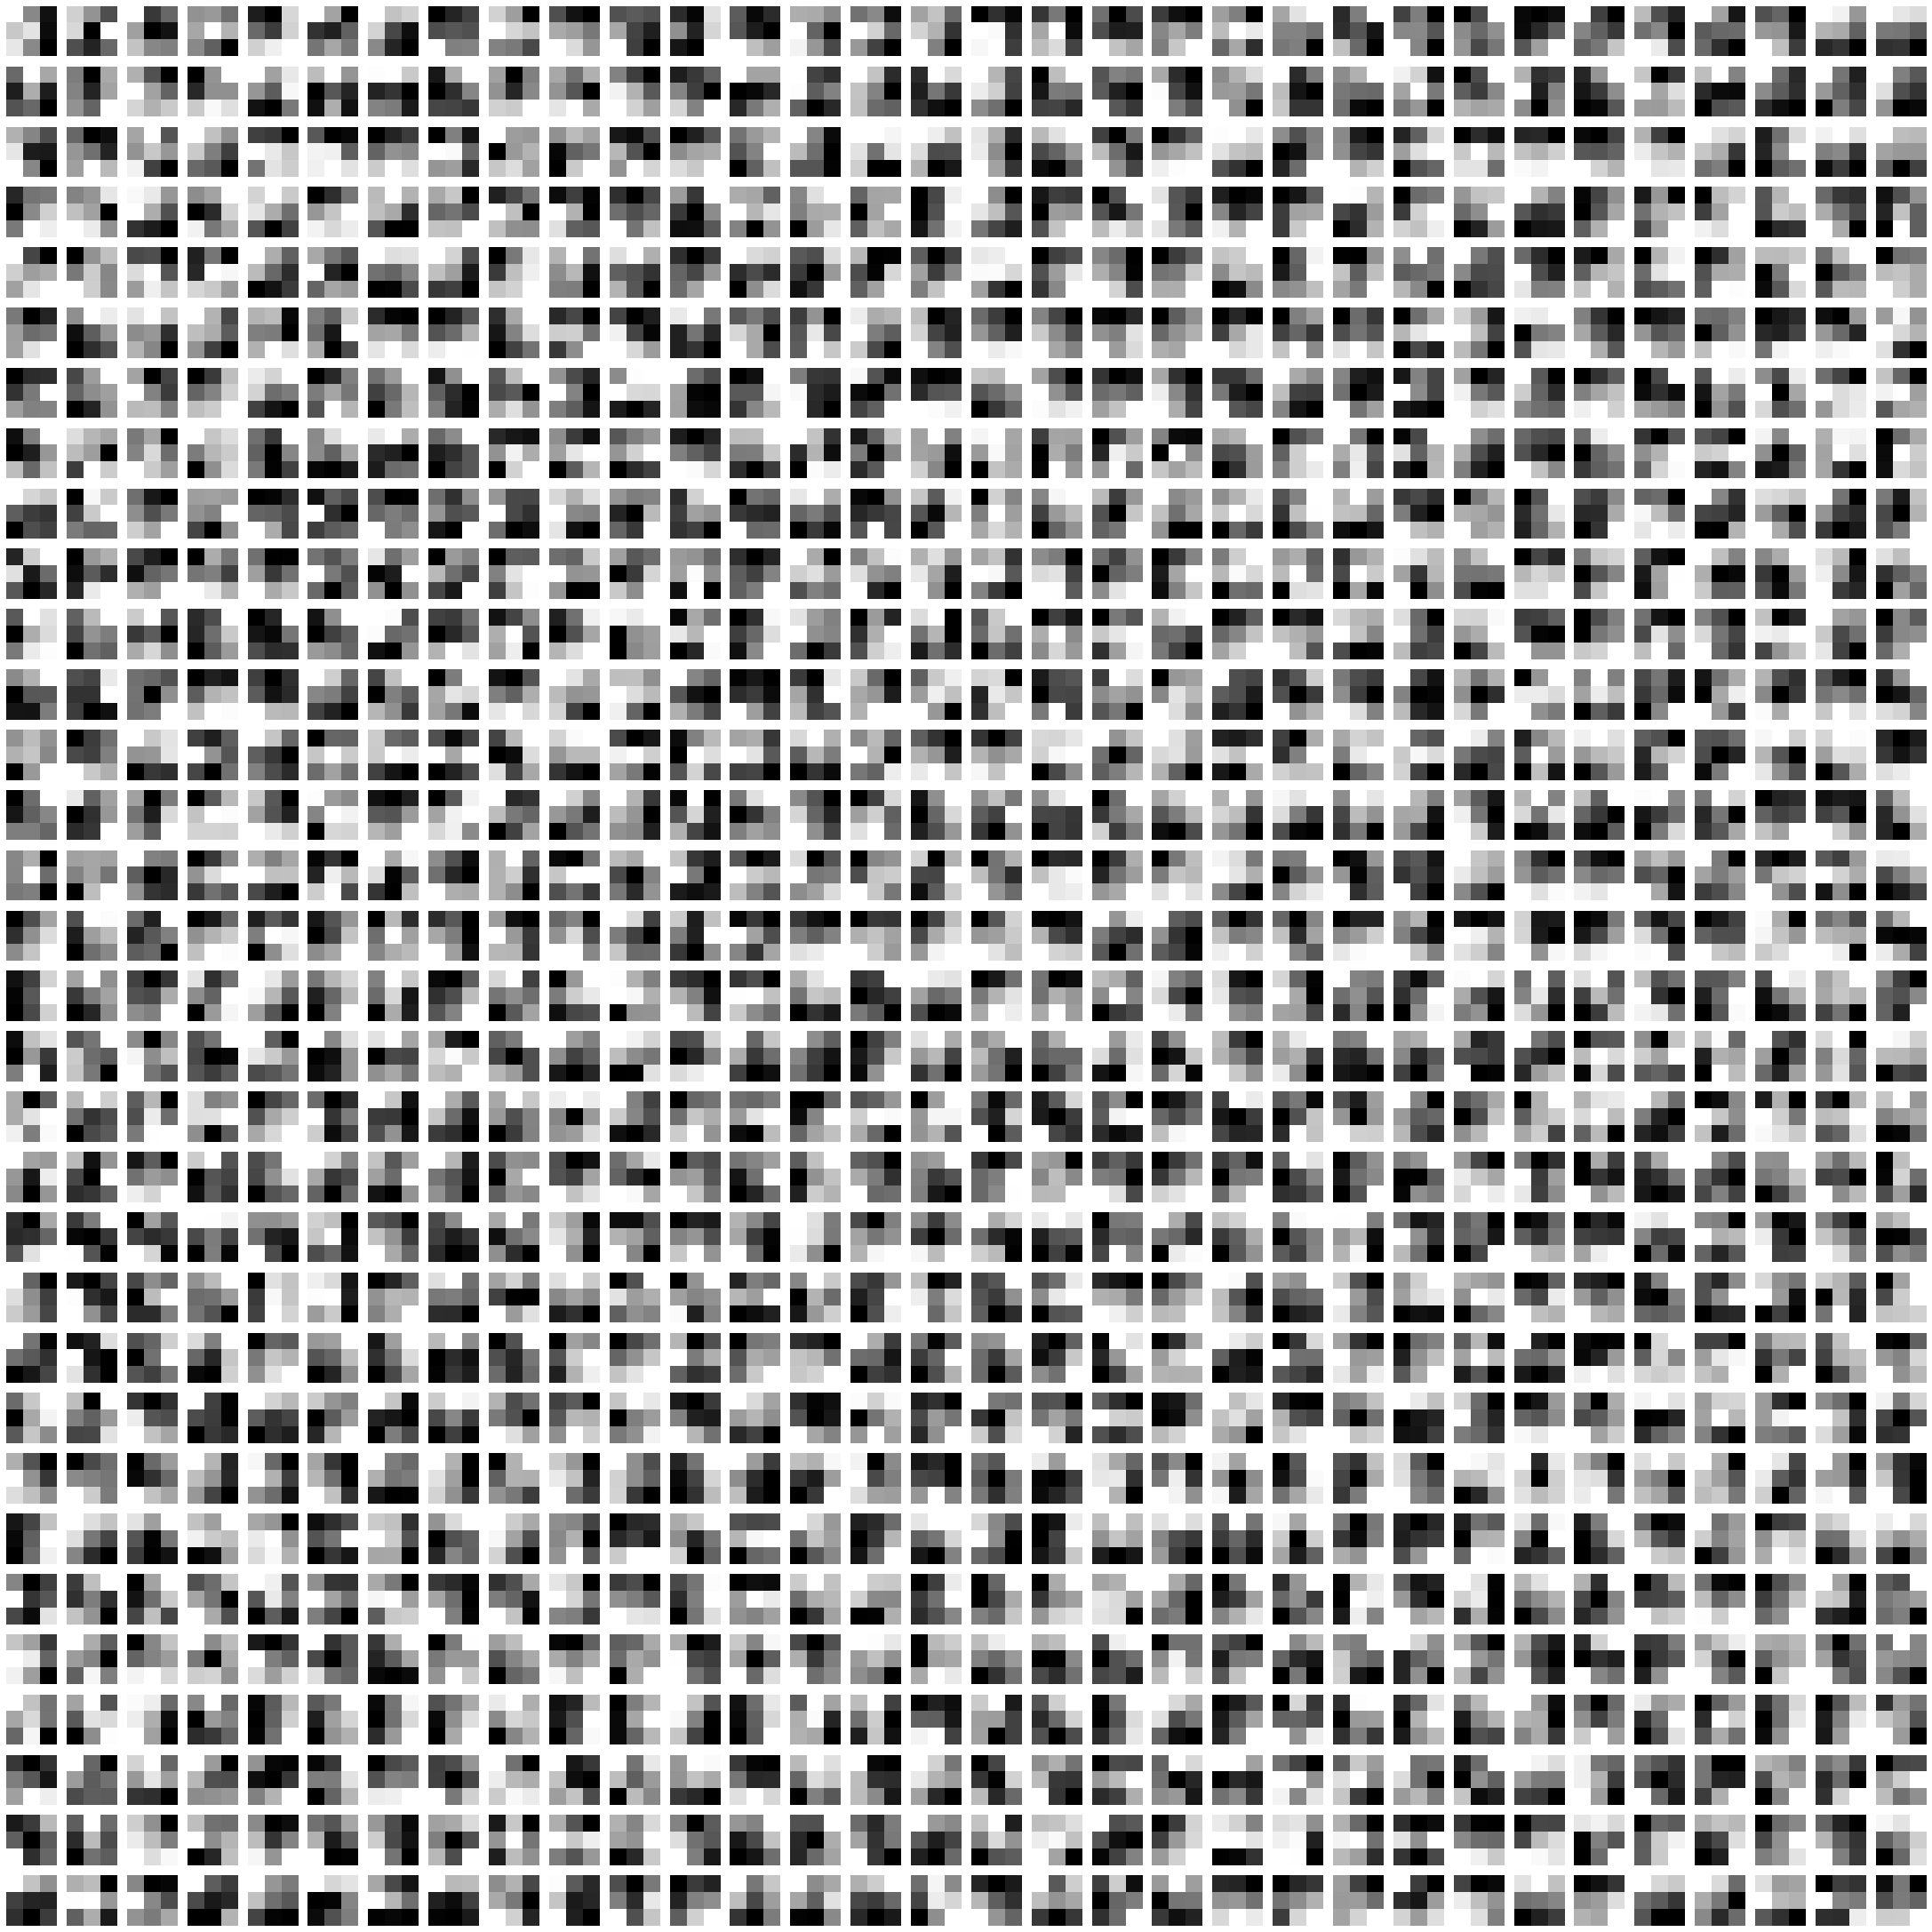

In [73]:
kernels = model.cnn4.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels,32)

### Convolution 5

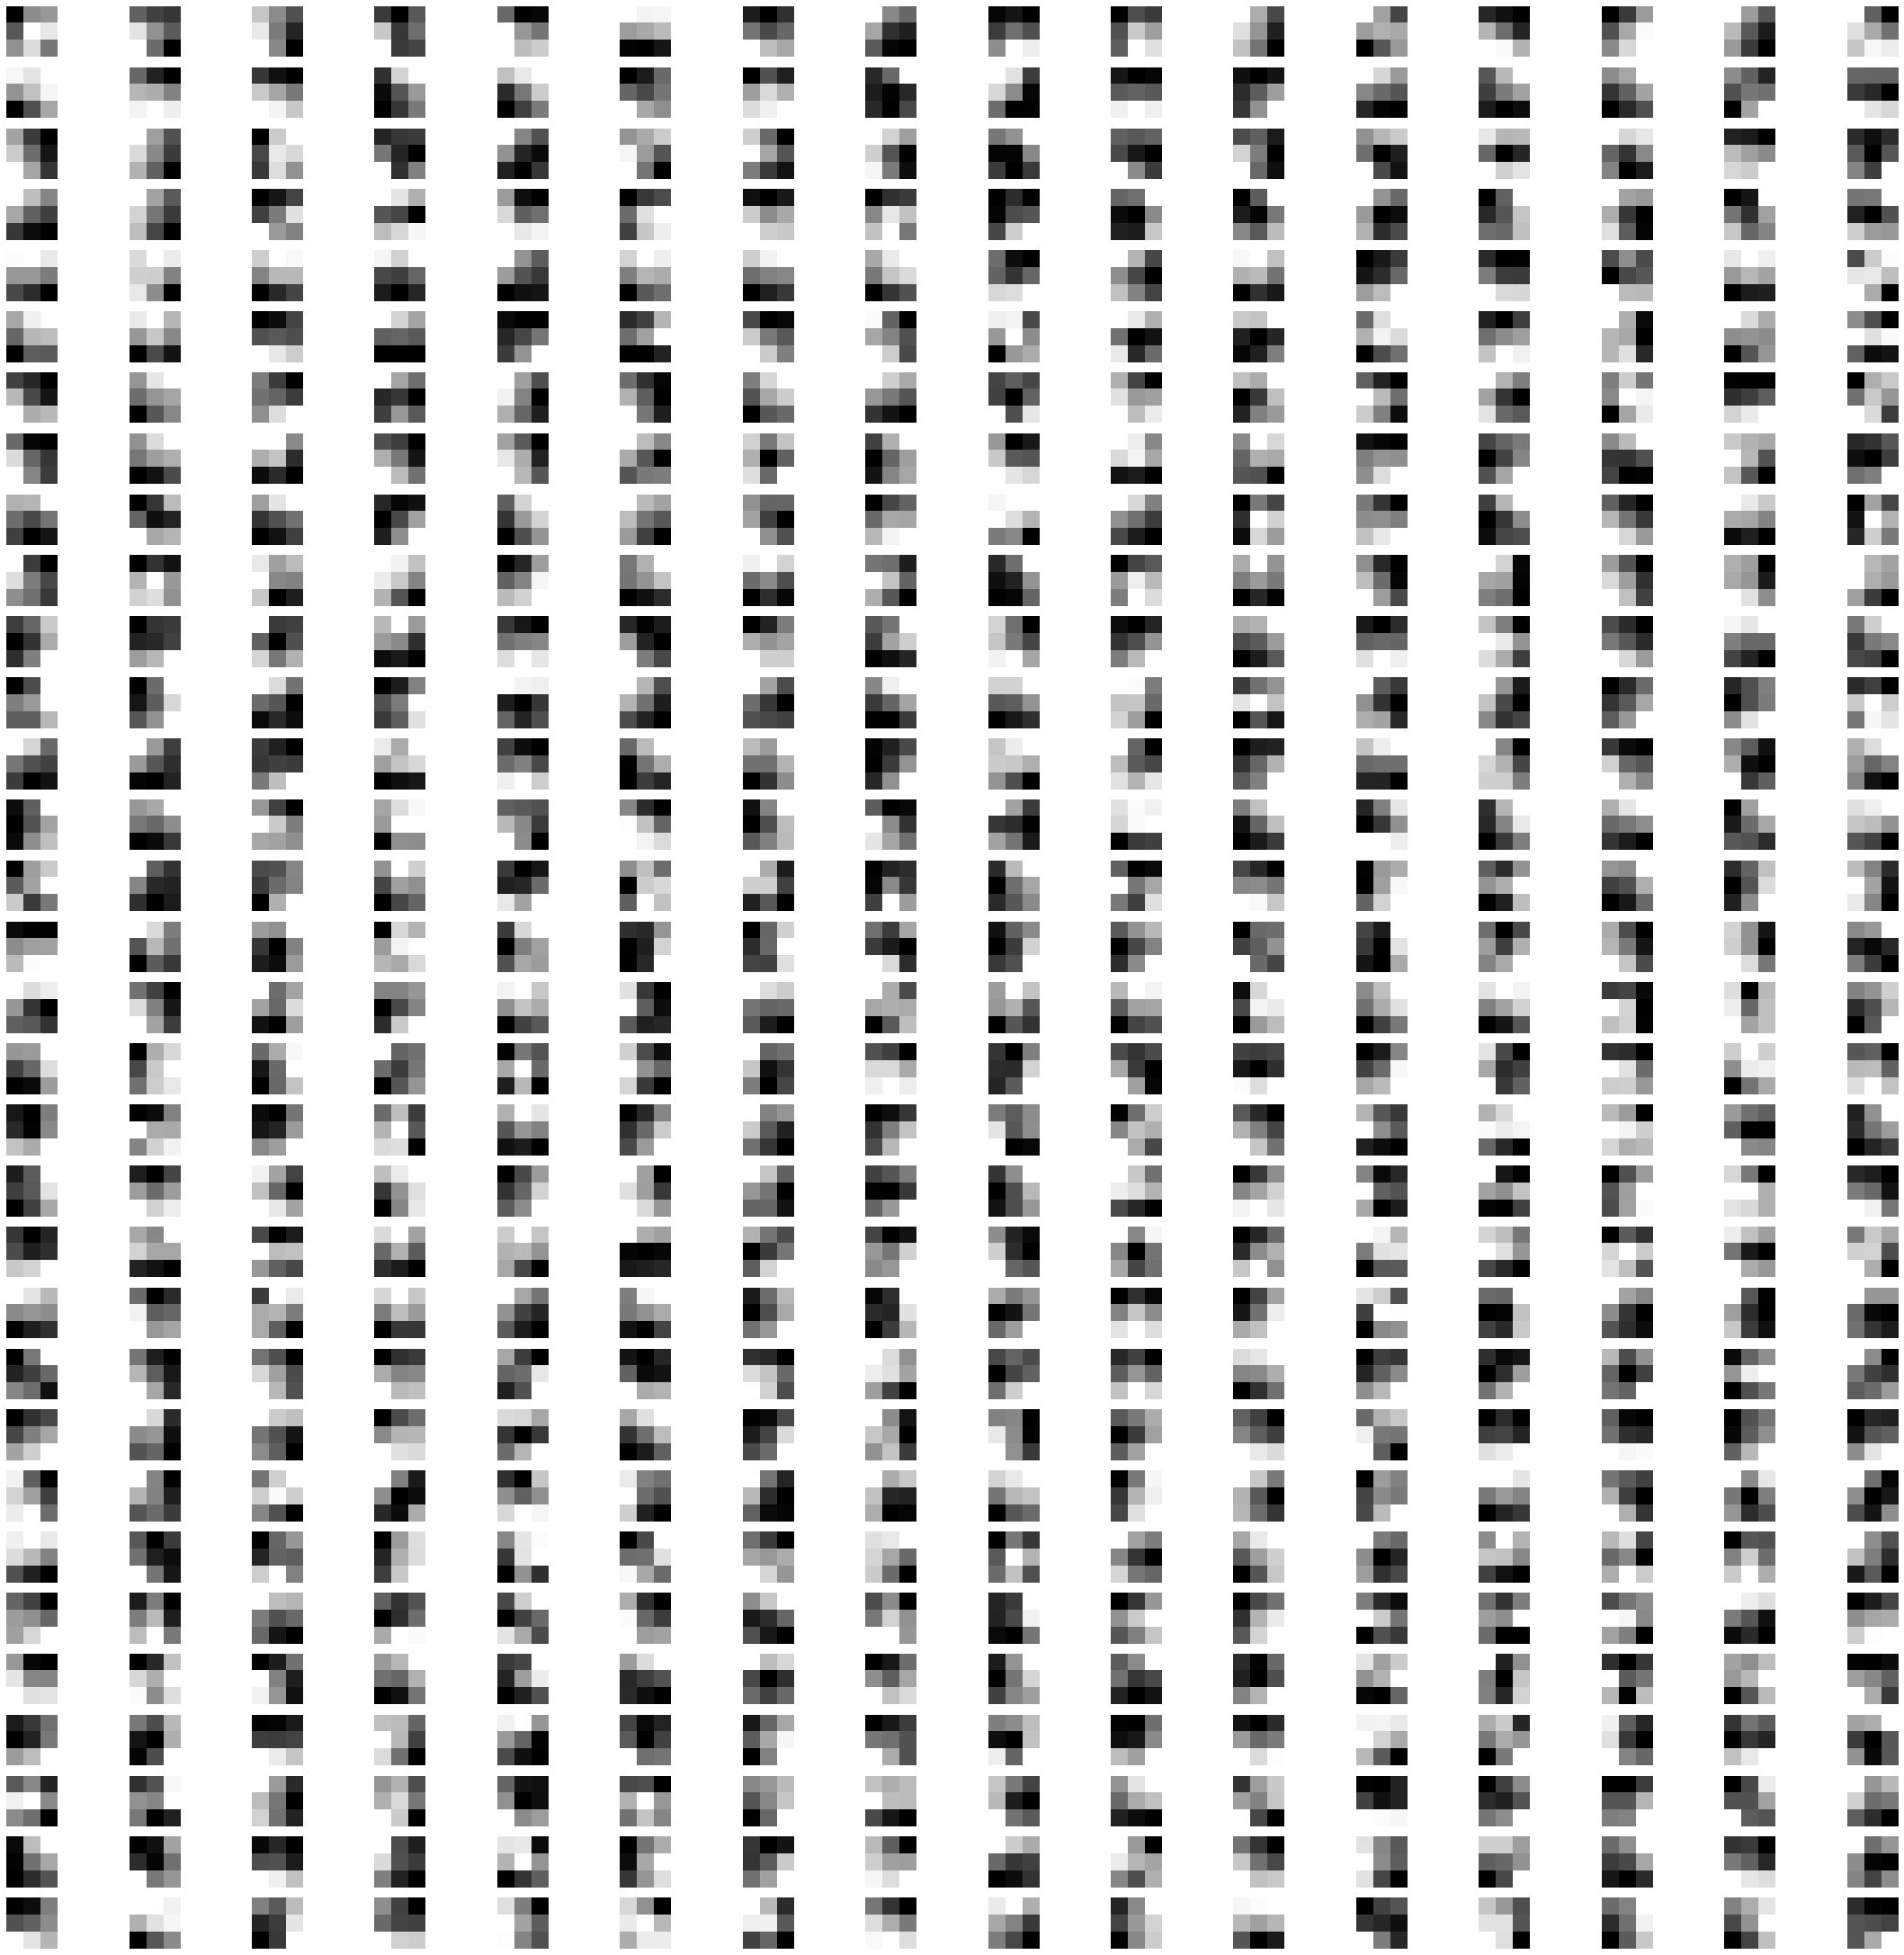

In [75]:
kernels = model.cnn5.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels,16)

### Convolution 6

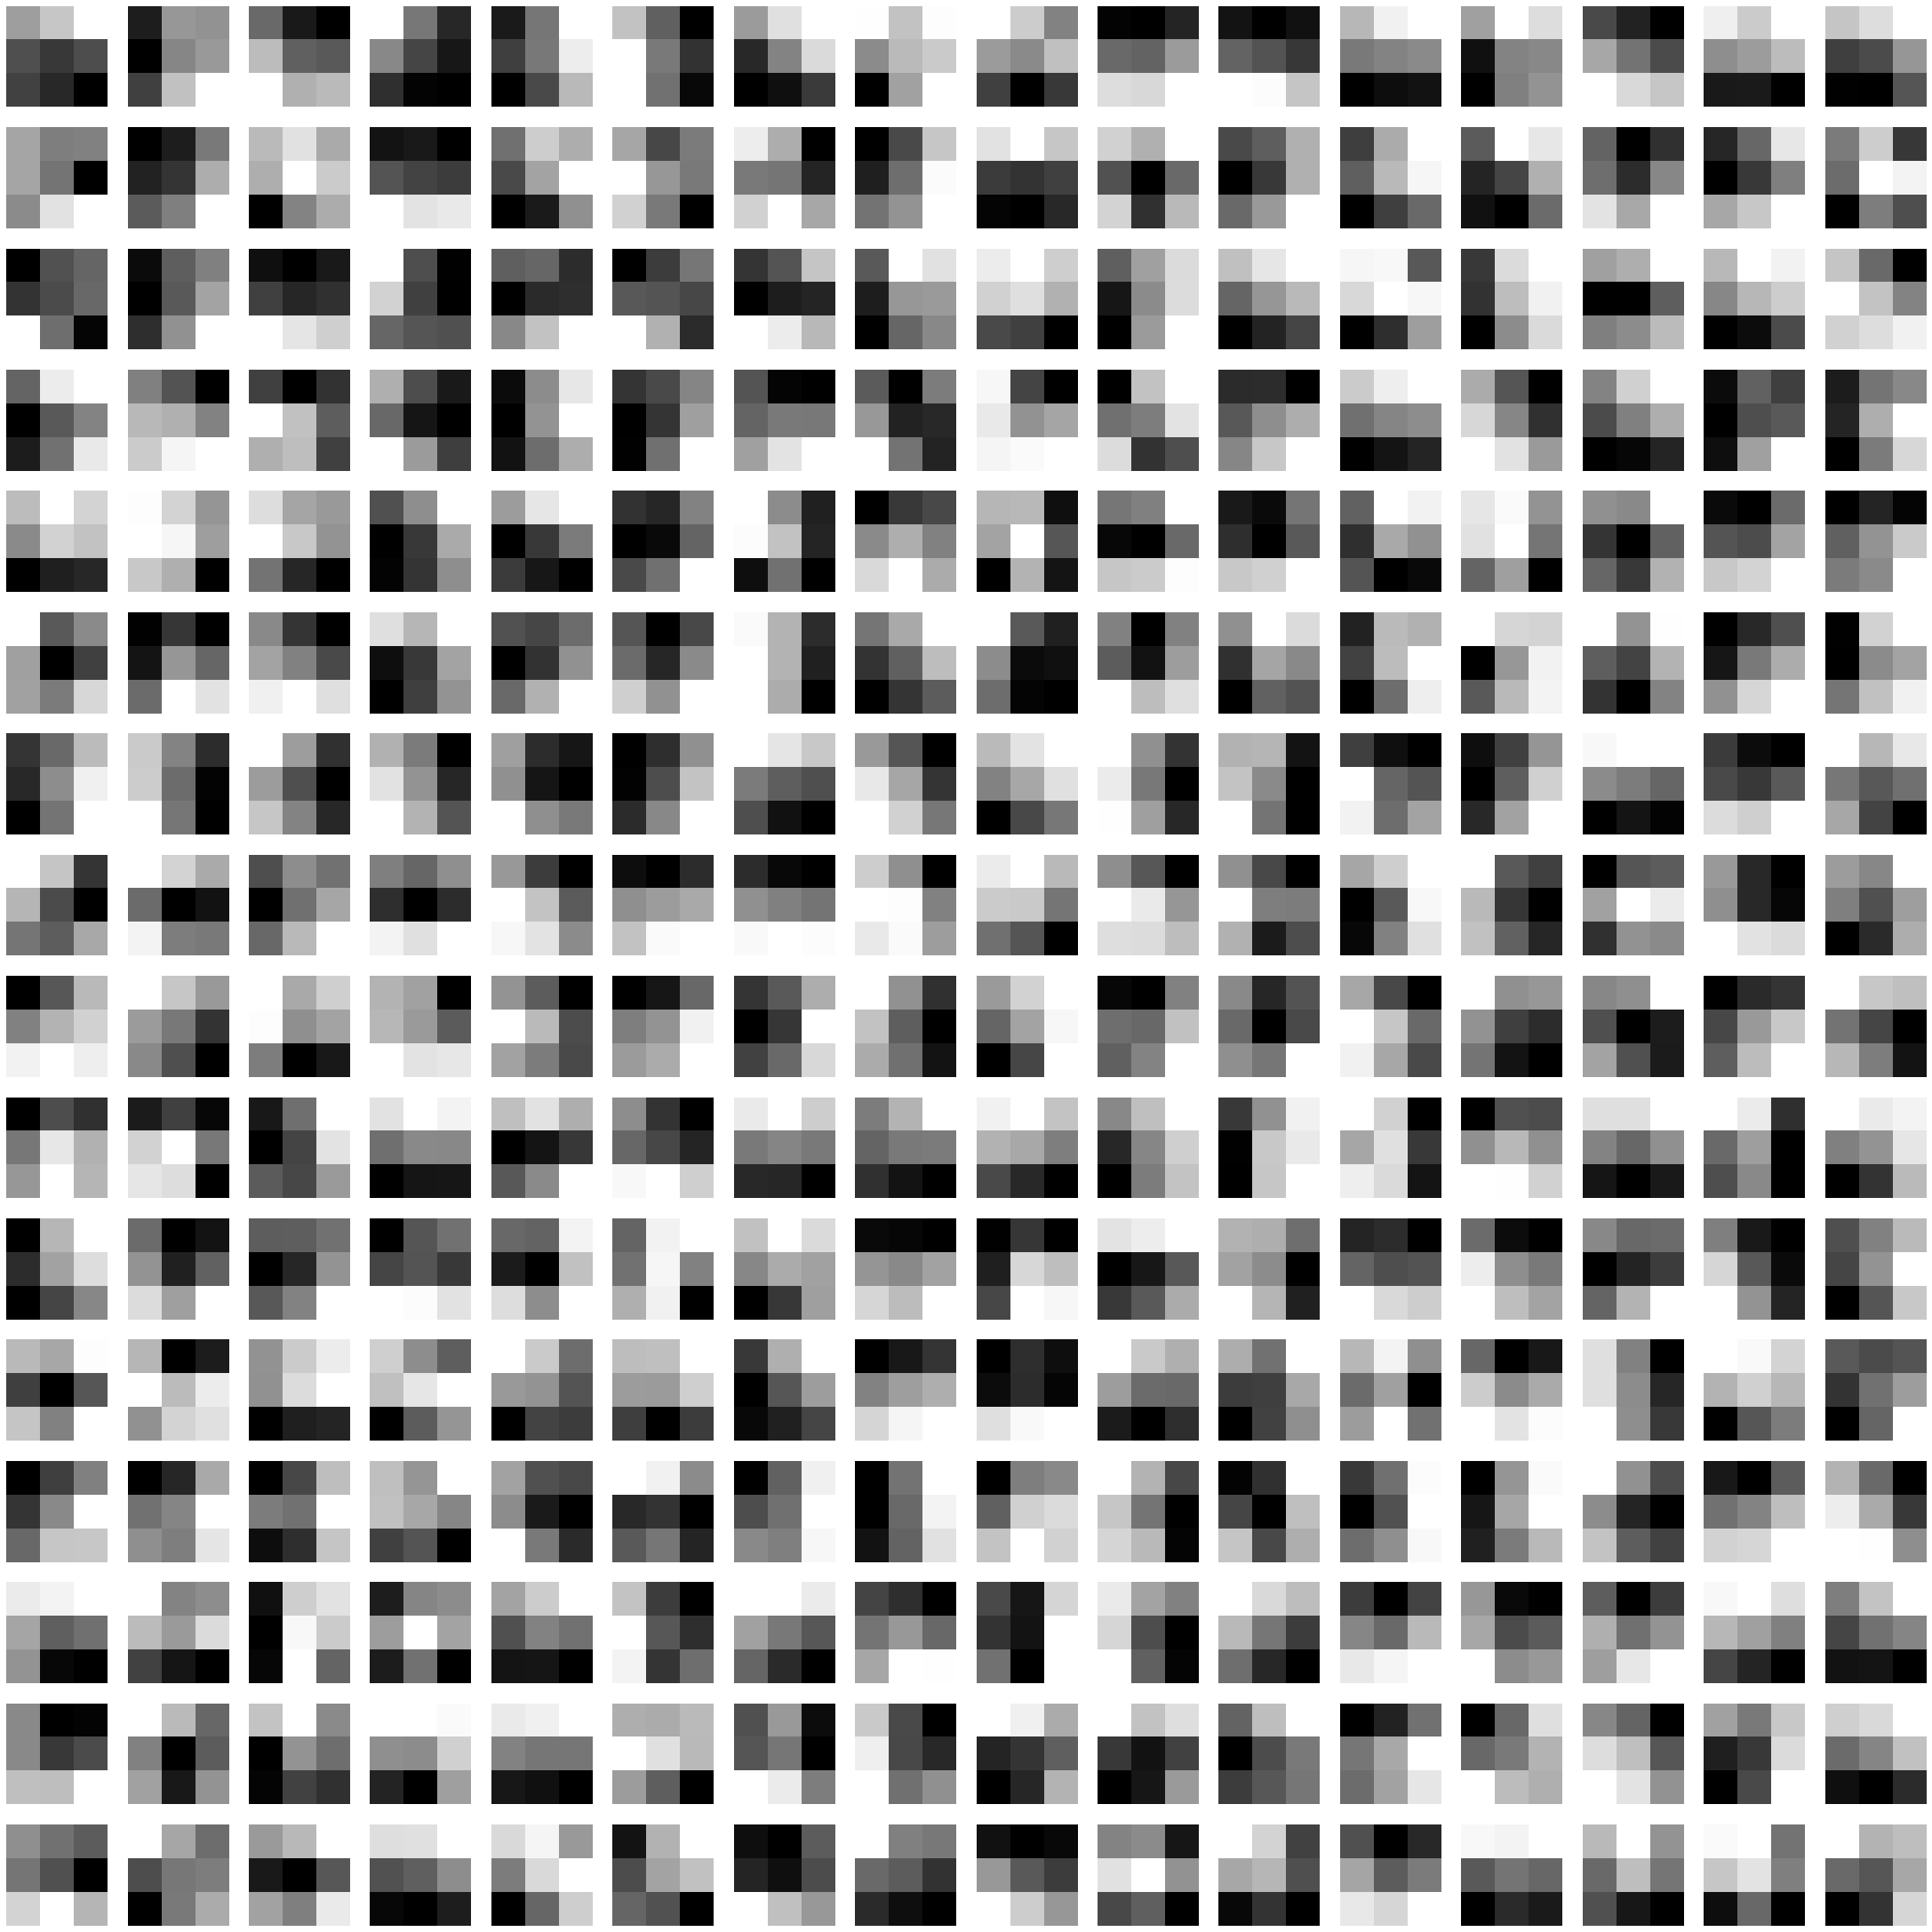

In [76]:
kernels = model.cnn6.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels,16)

## Max pooling VS Average Pooling

### CNN model class

In [137]:
class CNN_2(nn.Module):
    def __init__(self,inp_channels=3,input_size=32,output_size=10):
        super(CNN_2, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=inp_channels,out_channels=64,kernel_size=3)
        self.relu1 = nn.ReLU()
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
        self.relu2 = nn.ReLU()
                
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3)
        self.relu3 = nn.ReLU()
        
        # Maxpool 1
        self.maxpool3 = nn.AvgPool2d(kernel_size=2)
                
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
        self.relu4 = nn.ReLU()
        self.cnn4_drop = nn.Dropout2d(0.2)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.relu5 = nn.ReLU()
        
        # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3)
        self.relu6 = nn.ReLU()
        
        # Fully Connected 1
        self.fc1 = nn.Linear(16*7*7,output_size)

        
    def forward(self,x):
        # x = 100,3,32,32
        
        # Convolution 1
        out = self.cnn1(x) # out = 100,64,30,30
        out = self.relu1(out)
        
        # Convolution 2
        out = self.cnn2(out) # out = 100,64,28,28
        out = self.relu2(out)
        
        # Convolution 3
        out = self.cnn3(out) # out = 100,32,26,26
        out = self.relu3(out)
        
        # Maxpool 1
        out = self.maxpool3(out) # out = 100,32,13,13
        
        # Convolution 4
        out = self.cnn4(out) # out = 100,32,11,11
        out = self.relu4(out)
        
        # Convolution 5
        out = self.cnn5(out) # out = 100,16,9,9
        out = self.relu5(out)
        
        # Convolution 6
        out = self.cnn6(out) # out = 100,16,7,7
        out = self.relu6(out)
        
        out = out.view(out.size(0),-1)
        
        # Fully Connected layer 1
        out = self.fc1(out)

        
        return out

In [138]:
model = CNN_2()

if torch.cuda.is_available():
    model.cuda()
EPOCHS = 1400

optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0742,rho=0.98,weight_decay=0.003)

criterion = nn.CrossEntropyLoss()
loss_save = torch.zeros(int(EPOCHS*len(train_data)/BATCH_SIZE))

iter = 0
done = False
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_save[iter] = loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter +=1
        if iter % 1000 == 0:
            # Print Loss
            test_accuracy = accuracy(test_loader,model)
            train_accuracy = accuracy(train_loader,model)
            print('Iteration: {}. Loss: {}, Test Accuracy: {},Train Accuracy: {}'.format(iter, loss.item(), test_accuracy,train_accuracy))

Iteration: 1000. Loss: 1.8344120979309082, Test Accuracy: 34.619998931884766,Train Accuracy: 34.16400146484375
Iteration: 2000. Loss: 1.588659644126892, Test Accuracy: 45.220001220703125,Train Accuracy: 45.59600067138672
Iteration: 3000. Loss: 1.4709880352020264, Test Accuracy: 46.79999923706055,Train Accuracy: 48.0359992980957
Iteration: 4000. Loss: 1.3482117652893066, Test Accuracy: 50.29999923706055,Train Accuracy: 52.2859992980957
Iteration: 5000. Loss: 1.2491968870162964, Test Accuracy: 53.099998474121094,Train Accuracy: 55.67399978637695
Iteration: 6000. Loss: 1.2836065292358398, Test Accuracy: 54.34000015258789,Train Accuracy: 57.01599884033203
Iteration: 7000. Loss: 1.1709297895431519, Test Accuracy: 54.45000076293945,Train Accuracy: 56.625999450683594
Iteration: 8000. Loss: 1.1344035863876343, Test Accuracy: 59.22999954223633,Train Accuracy: 61.75600051879883
Iteration: 9000. Loss: 0.9868036508560181, Test Accuracy: 61.63999938964844,Train Accuracy: 64.25399780273438
Iteration

### Learning Curve

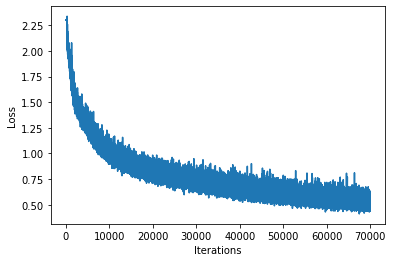

In [139]:
ax = sns.lineplot(data = loss_save.numpy())
ax.set(xlabel = "Iterations", ylabel="Loss")
plt.show()

### The effect of choosing a pooling method was not very crucial in case of CIFAR, 
### but Average Pooling seems to perform better than the Max Pooling as the gradient descent was less smoother in later case.

## Relation between Conv Layer and FC

### Let there be two Fully Connected layers, an input layer with $n$ neurons and an output layer with $m$ neurons.

### This can be implemented with a Convolutional Layer having $m$ filters with each filterhaving $n$ neurons.